In [1]:
import numpy as np
from astroML.datasets import sdss_corrected_spectra
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [2]:
mpl.rcParams['figure.dpi'] = 300

In [3]:
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')

In [4]:
data = np.load('/epyc/users/sportill/specAE/spec64k.npz')
rawspec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

In [5]:
# match VAE training
spec = rawspec / data['norms'][:,None] # normalize spectra with PCA norm
meanspec = np.mean(spec, axis=0)
nfeat = meanspec.size

In [6]:
# matches VAE training
spec_err = data['spec_err'] / data['norms'][:,None]
lowspecerr = (data['spec_err'] < 0.25) # some errors ~ 0 or are negative?
spec_weig = 1./(spec_err*spec_err + 1./(2e6)) # cap weights
spec_mask = data['mask']
spec_weig[spec_mask] = 0 # if spectrum masked, act as if err = inf
spec_weig[lowspecerr] = 0
spec_err[spec_mask] = float('nan')
spec_err[lowspecerr] = float('nan')

In [7]:
specclass = data['lineindex_cln']
# stars have lineindex_cln 1, 9
stars = (specclass == 1) + (specclass == 9)
starsidx = np.where(stars)[0]
# map lineindex_cln 2,3 to 0 and 4,5,6 to 1,2,3
specclass -= 3
specclass[specclass == -1] = 0 # set line_index 2 -> 0
specclass[specclass < -1] = -1
specclass[specclass > 3] = -1
specclassnames = ['quiescent galaxy', 'emission-line galaxy', 'narrow-line AGN', 'broad-line AGN']

In [8]:
def show_top_models(tag):
    metrics = np.load(tag+'/metrics.npz')
    order = np.argsort(metrics['MSE'])
    for i in order[0:10]:
        m = torch.load(tag+'/%04i.pth' % i)
        print('Model %04i MSE %0.3e KLD %0.2e MMD %0.2e lambda %0.2e nhidden %i %i' % (i, metrics['MSE'][i], metrics['KLD'][i], metrics['MMD'][i], m.lambd, m.encd.out_features, m.enc2.out_features))

In [9]:
model = torch.load('64k_20190612/0057.pth')
model.eval()

/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


InfoVAE(
  (encd): Linear(in_features=1000, out_features=549, bias=True)
  (d1): Dropout(p=0, inplace=False)
  (enc2): Linear(in_features=549, out_features=110, bias=True)
  (d2): Dropout(p=0, inplace=False)
  (mu): Linear(in_features=110, out_features=10, bias=True)
  (lv): Linear(in_features=110, out_features=10, bias=True)
  (decd): Linear(in_features=10, out_features=110, bias=True)
  (d3): Dropout(p=0, inplace=False)
  (dec2): Linear(in_features=110, out_features=549, bias=True)
  (d4): Dropout(p=0, inplace=False)
  (outp): Linear(in_features=549, out_features=1000, bias=True)
)

In [10]:
ds = np.load('64k_20190612/datasplit.npz')
valididx = ds['valididx']
trainidx = ds['trainidx']

allidx = np.concatenate((valididx, trainidx))

In [11]:
plate_mjd_fiber = np.column_stack((data['plate'], data['mjd'], data['fiber']))

In [12]:
with torch.no_grad():
    reconspec, latentmu, latentlv = model(torch.tensor(spec - meanspec, dtype=torch.float32))
    reconspec = reconspec.numpy()
    latentmu = latentmu.numpy()
    latentlv = latentlv.numpy()

In [13]:
latent_PCA = PCA()
latent_PCA.fit(latentmu[trainidx])
latentmu_PCA = latent_PCA.transform(latentmu)

# Make tracks in latent space

In [14]:
cmapclass = plt.get_cmap('Accent')

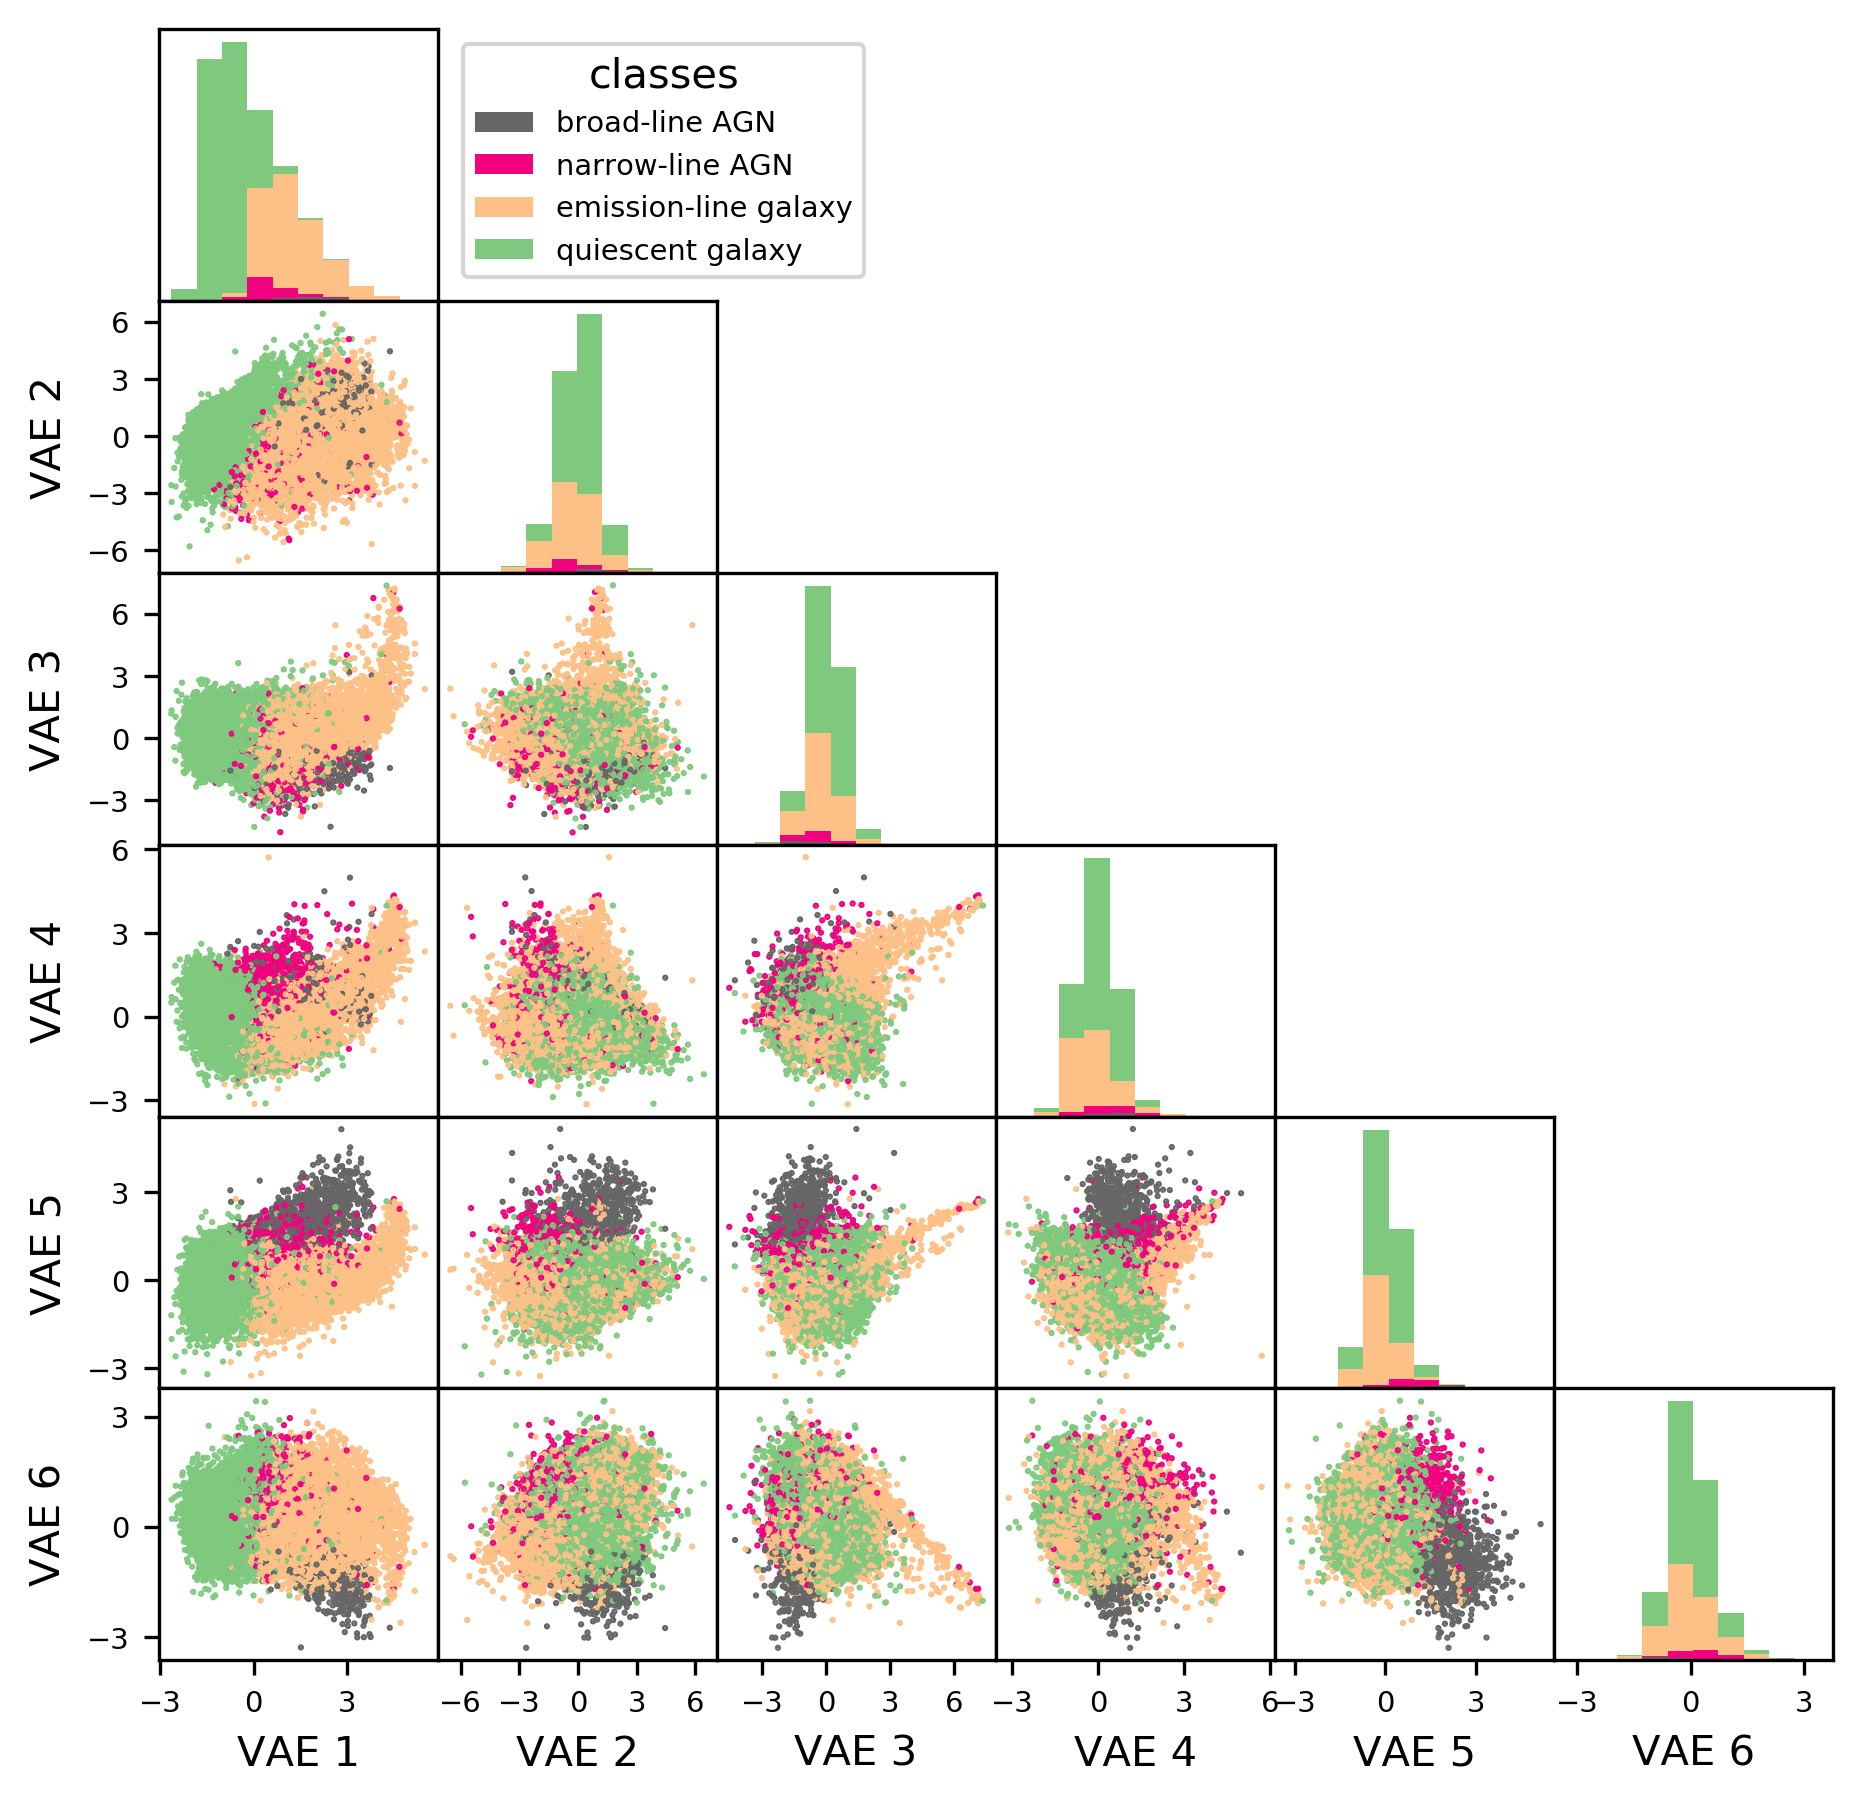

In [15]:
fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(6):
    for j in range(6):
        if i <= j:
            plt.subplot(6,6,i+j*6+1)
            if i == 0 and j != 0:
                plt.ylabel('VAE %i' % (j + 1))
            if j == 5:
                plt.xlabel('VAE %i' % (i + 1))
            if i != 0:
                plt.yticks([])
            else:
                plt.yticks([-6,-3,0,3,6])
            if j != 5:
                plt.xticks([])
            else:
                plt.xticks([-6,-3,0,3,6])
            if i < j:
                plt.scatter(latentmu_PCA[allidx,i], latentmu_PCA[allidx,j],s=1,marker='.',c=specclass[allidx], cmap=cmapclass)
                
            if i == j:
                plt.hist([latentmu_PCA[specclass == cln, i] for cln in [3,2,1,0]], stacked=True, \
                         label=specclassnames[::-1], \
                         color=[cmapclass(x) for x in [1., 2/3, 1/3, 0.]])
                plt.yticks([])
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='classes')
plt.savefig('figures/cornerplot.png')
plt.show()

In [16]:
def track_coords(quantity, percentiles, mask):
    coords = np.zeros((len(percentiles)-1, model.ncode))
    for i in range(len(percentiles)-1):
        thismask = mask & \
            (quantity >= np.percentile(quantity, percentiles[i])) & \
            (quantity < np.percentile(quantity, percentiles[i+1]))
        coords[i,:] = np.mean(latentmu_PCA[thismask,:], axis=0)
    return coords

In [17]:
coordsSF = track_coords(latentmu_PCA[:,0], [0, 30, 60, 90, 95, 100], (specclass == 0) | (specclass == 1))
coordsEM = track_coords(latentmu_PCA[:,2] + latentmu_PCA[:,3], \
                        [99, 99.5, 99.75, 99.9, 100], \
                        specclass > -1)
coordsAGN = track_coords(latentmu_PCA[:,4] - latentmu_PCA[:,5], [0, 95, 98, 99, 99.75, 100], specclass >= 2)
coordsPSB = track_coords(latentmu_PCA[:,1], [0, 1, 5, 95, 99, 100], (specclass == 0) | (specclass == 1))

In [18]:
def focus_tracks(tracklist, letters, dimx, dimy):
#    fig.subplots_adjust(hspace=0, wspace=0)
    plt.scatter(latentmu_PCA[allidx,dimx], latentmu_PCA[allidx,dimy],s=1,marker='.',c=specclass[allidx], cmap=cmapclass)
    for i, coords in enumerate(tracklist):
        plt.plot(coords[:,dimx],coords[:,dimy], c='k')
        for j in range(coords.shape[0]):
            plt.text(coords[j,dimx], coords[j,dimy], letters[i]+'%i' % (j+1), fontsize='xx-small', \
                     bbox={'boxstyle': 'round', 'facecolor': 'white'}, horizontalalignment='center', verticalalignment='center')

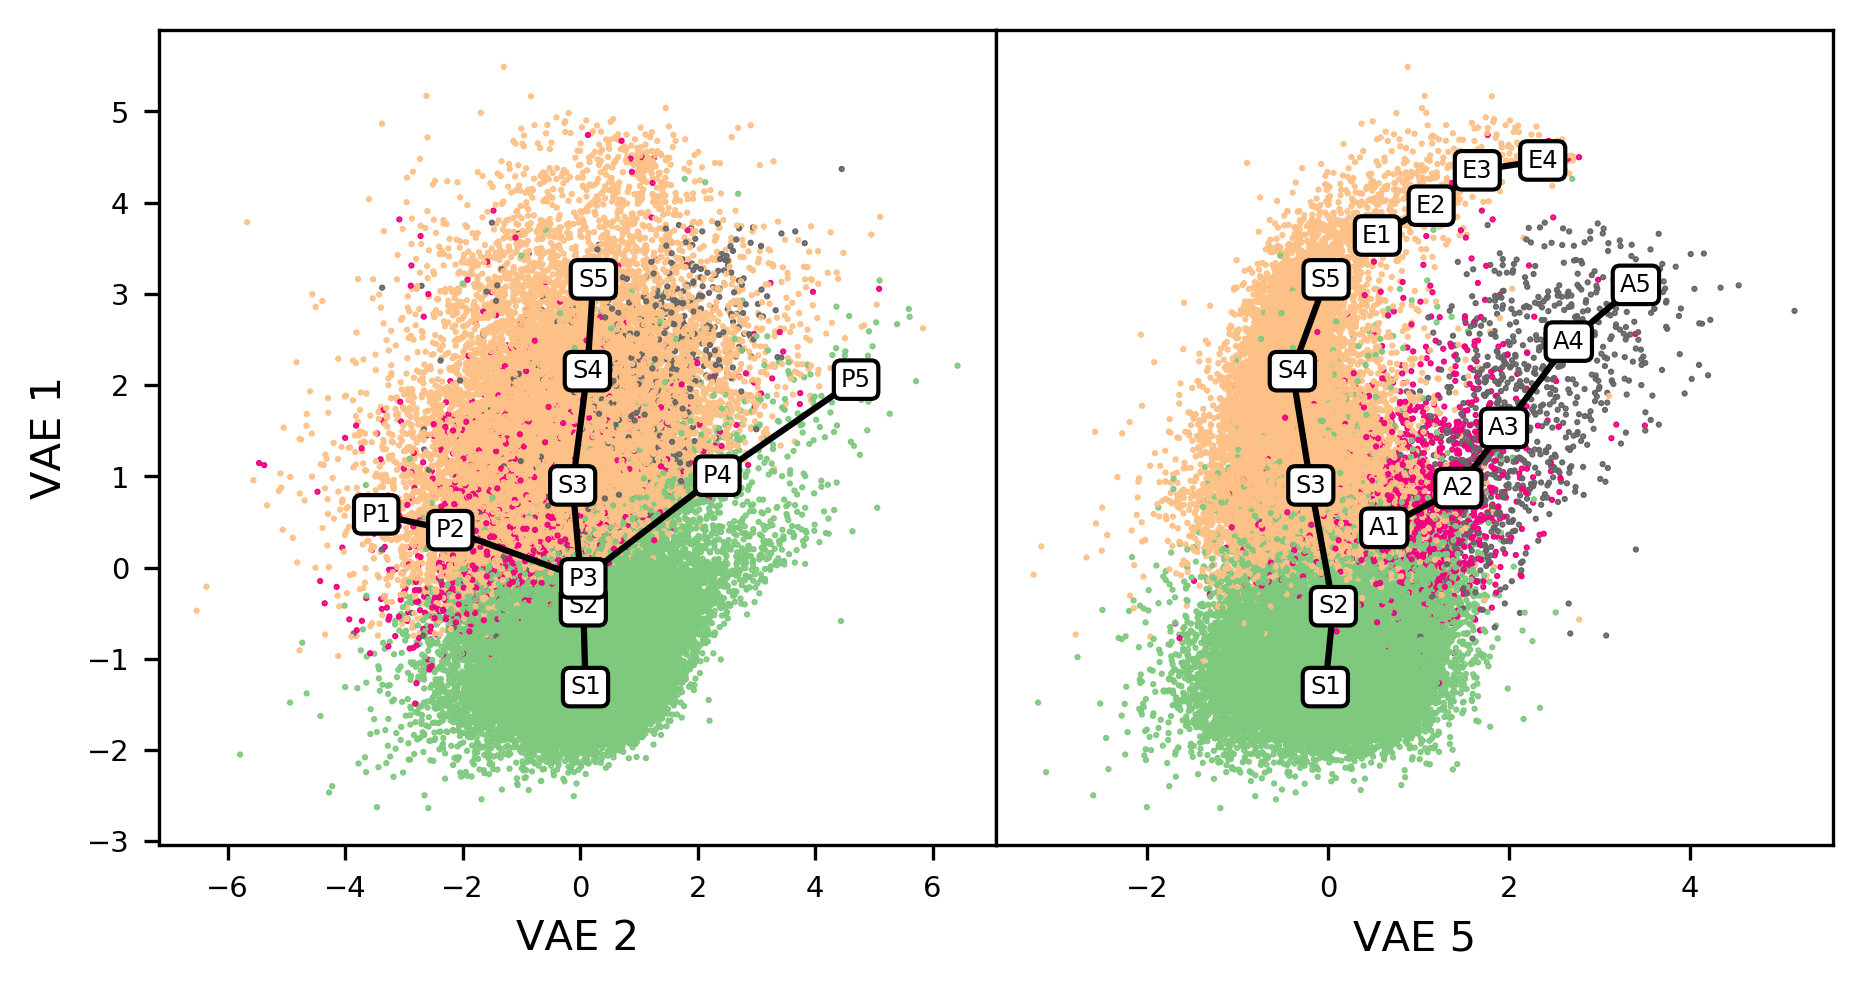

In [19]:
fig = plt.figure(figsize=(7.2, 3.6))
fig.subplots_adjust(hspace=0, wspace=0)
plt.subplot(1,2,1)
focus_tracks([coordsSF, coordsPSB], ['S', 'P'], 1, 0)
plt.ylabel('VAE 1')
plt.xlabel('VAE 2')
plt.subplot(1,2,2)
focus_tracks([coordsSF, coordsEM, coordsAGN], ['S', 'E', 'A'], 4, 0)
plt.yticks([])
plt.xlabel('VAE 5')
plt.savefig('figures/ztracks.png')
plt.show()

In [20]:
def plot_track(coords, offset=1, ymax=None, letter='', labels=True):
    with torch.no_grad():
        recon_batch = model.decode(torch.tensor(latent_PCA.inverse_transform(coords), dtype=torch.float32)).numpy() + meanspec
        recon_batch /= np.mean(recon_batch, axis=1)[:,None]
        cmapseq = plt.get_cmap("viridis")
        for i in range(coords.shape[0])[::-1]:
            color = cmapseq(i / coords.shape[0])
            plt.plot(lam, recon_batch[i] + i*offset, c=color, lw=1)
            if labels:
                plt.text(lam[-1], recon_batch[i,-1] + i*offset, ' '+letter+'%i' % (i+1), color=color, fontsize='small')
        plt.ylim(0,ymax)
        if labels:
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Normalized Flux + Offset')

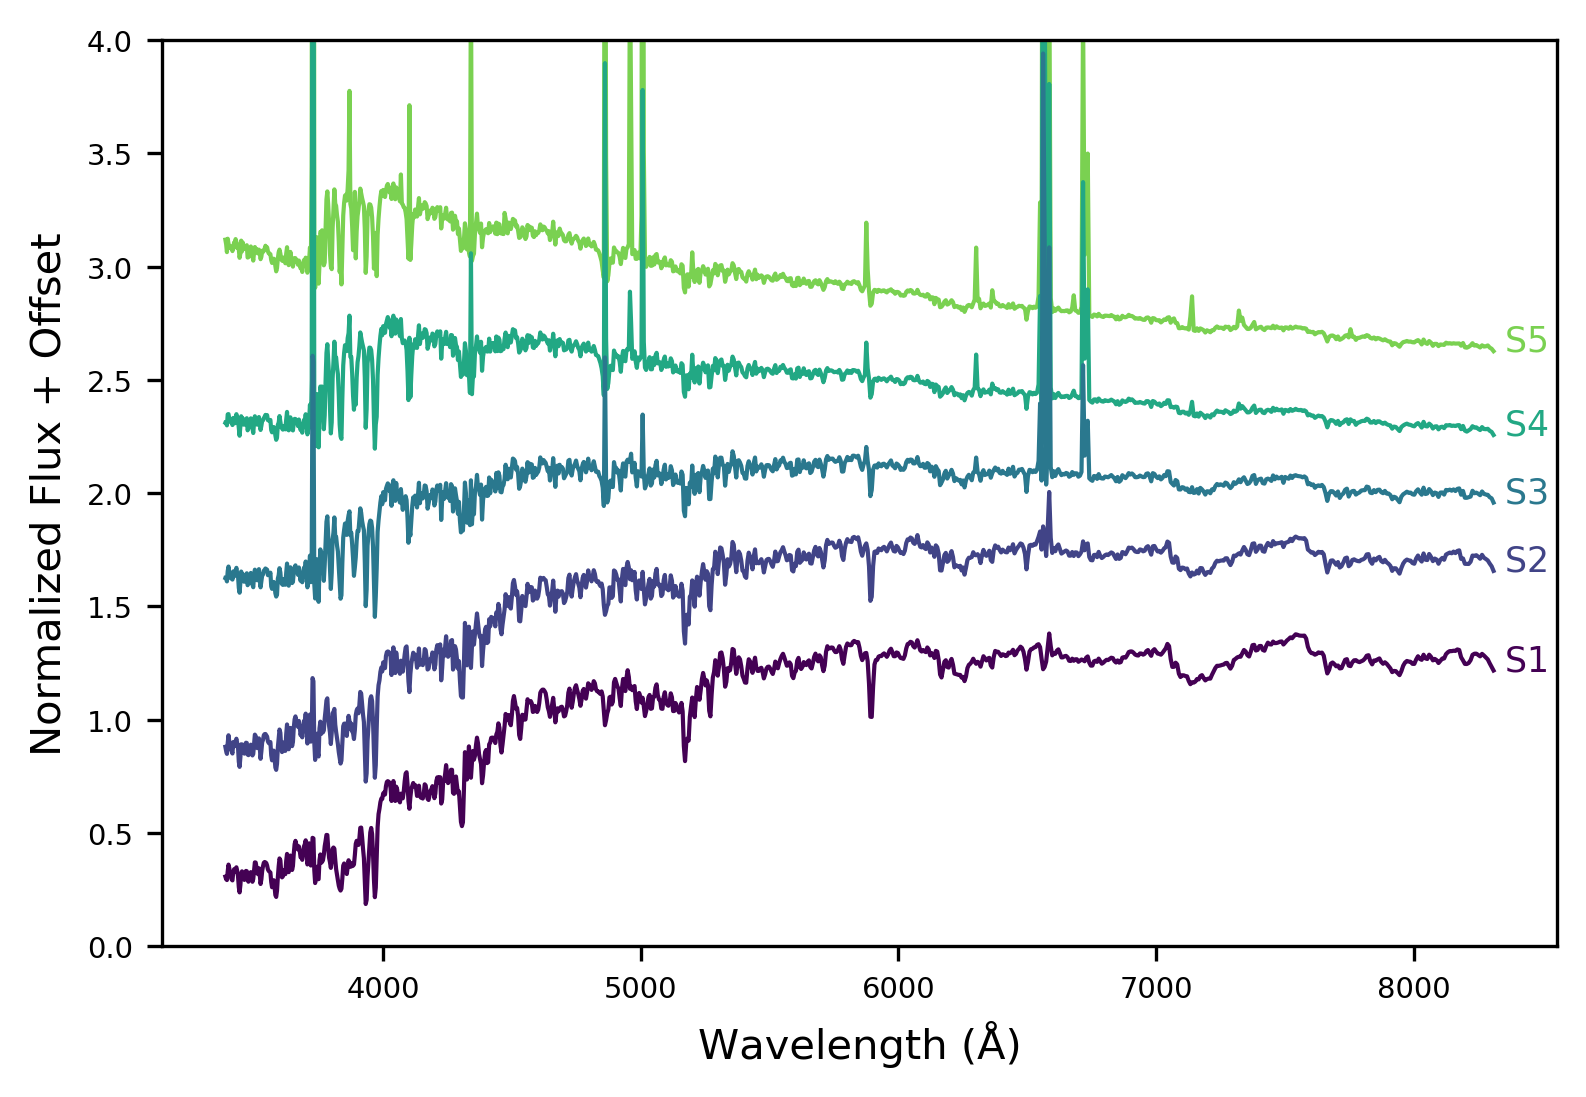

In [21]:
plot_track(coordsSF, offset=0.5, letter='S', ymax=4)
plt.savefig('figures/SFtrack.pdf')
plt.show()

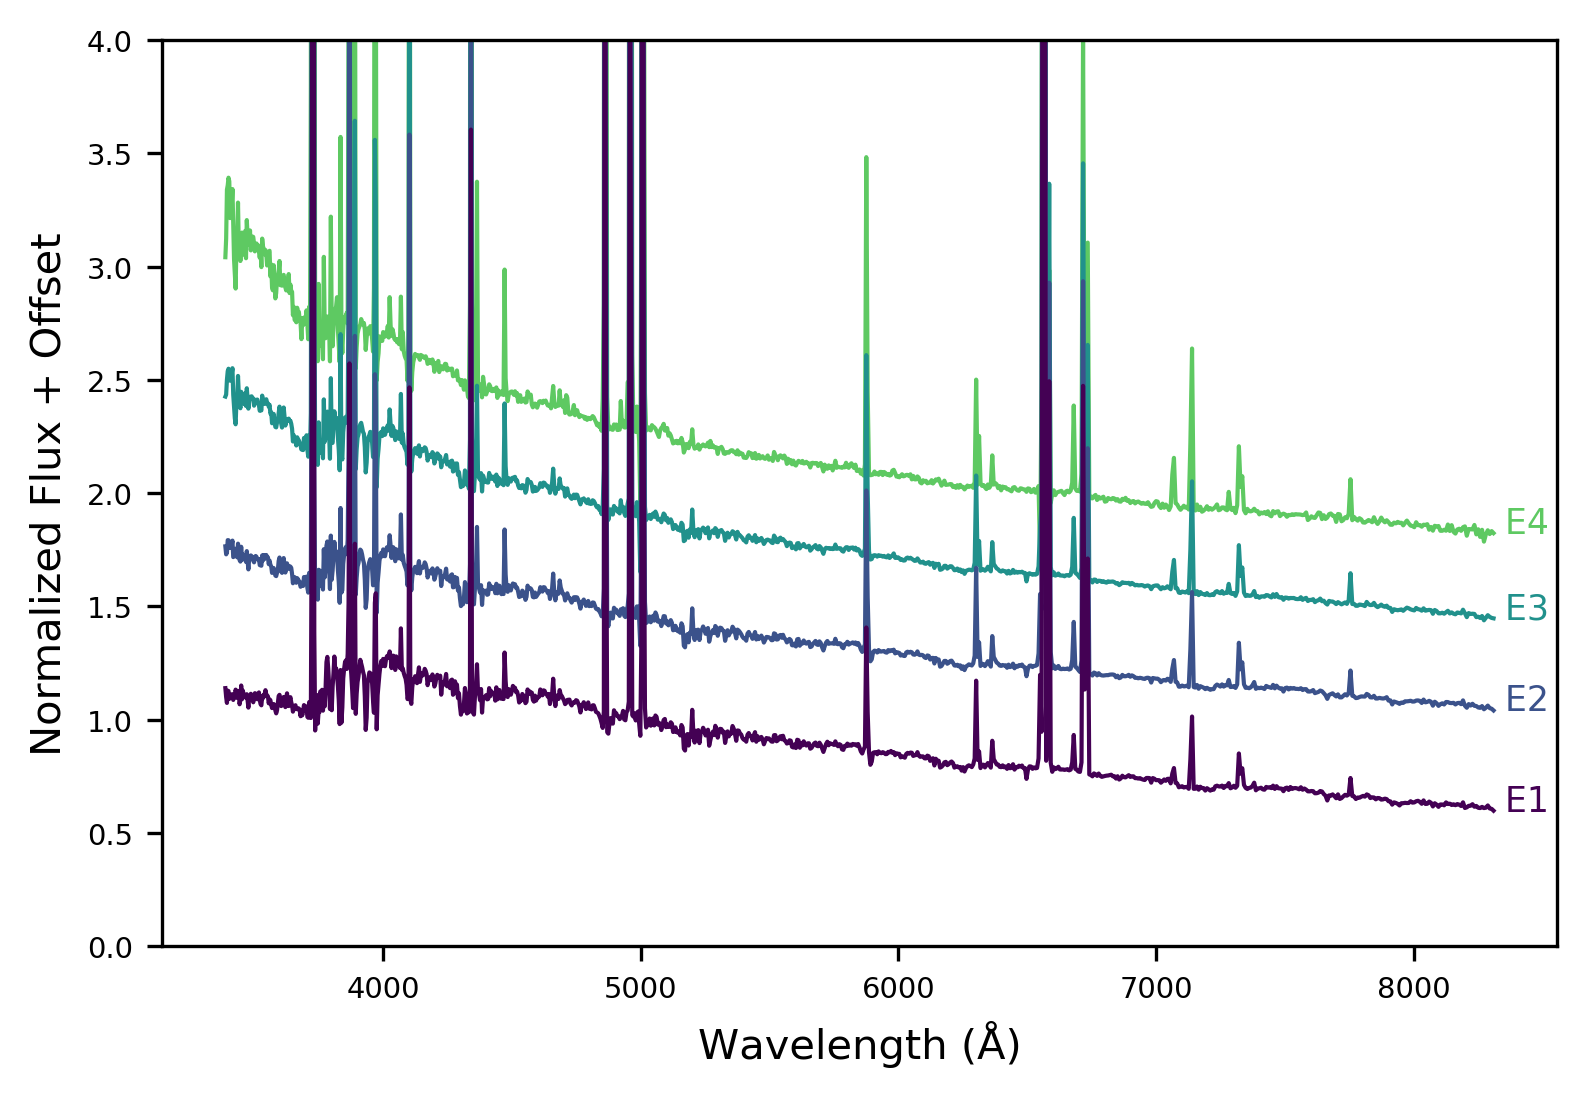

In [22]:
plot_track(coordsEM, offset=0.5, letter='E', ymax=4)
plt.savefig('figures/ELtrack.pdf')
plt.show()

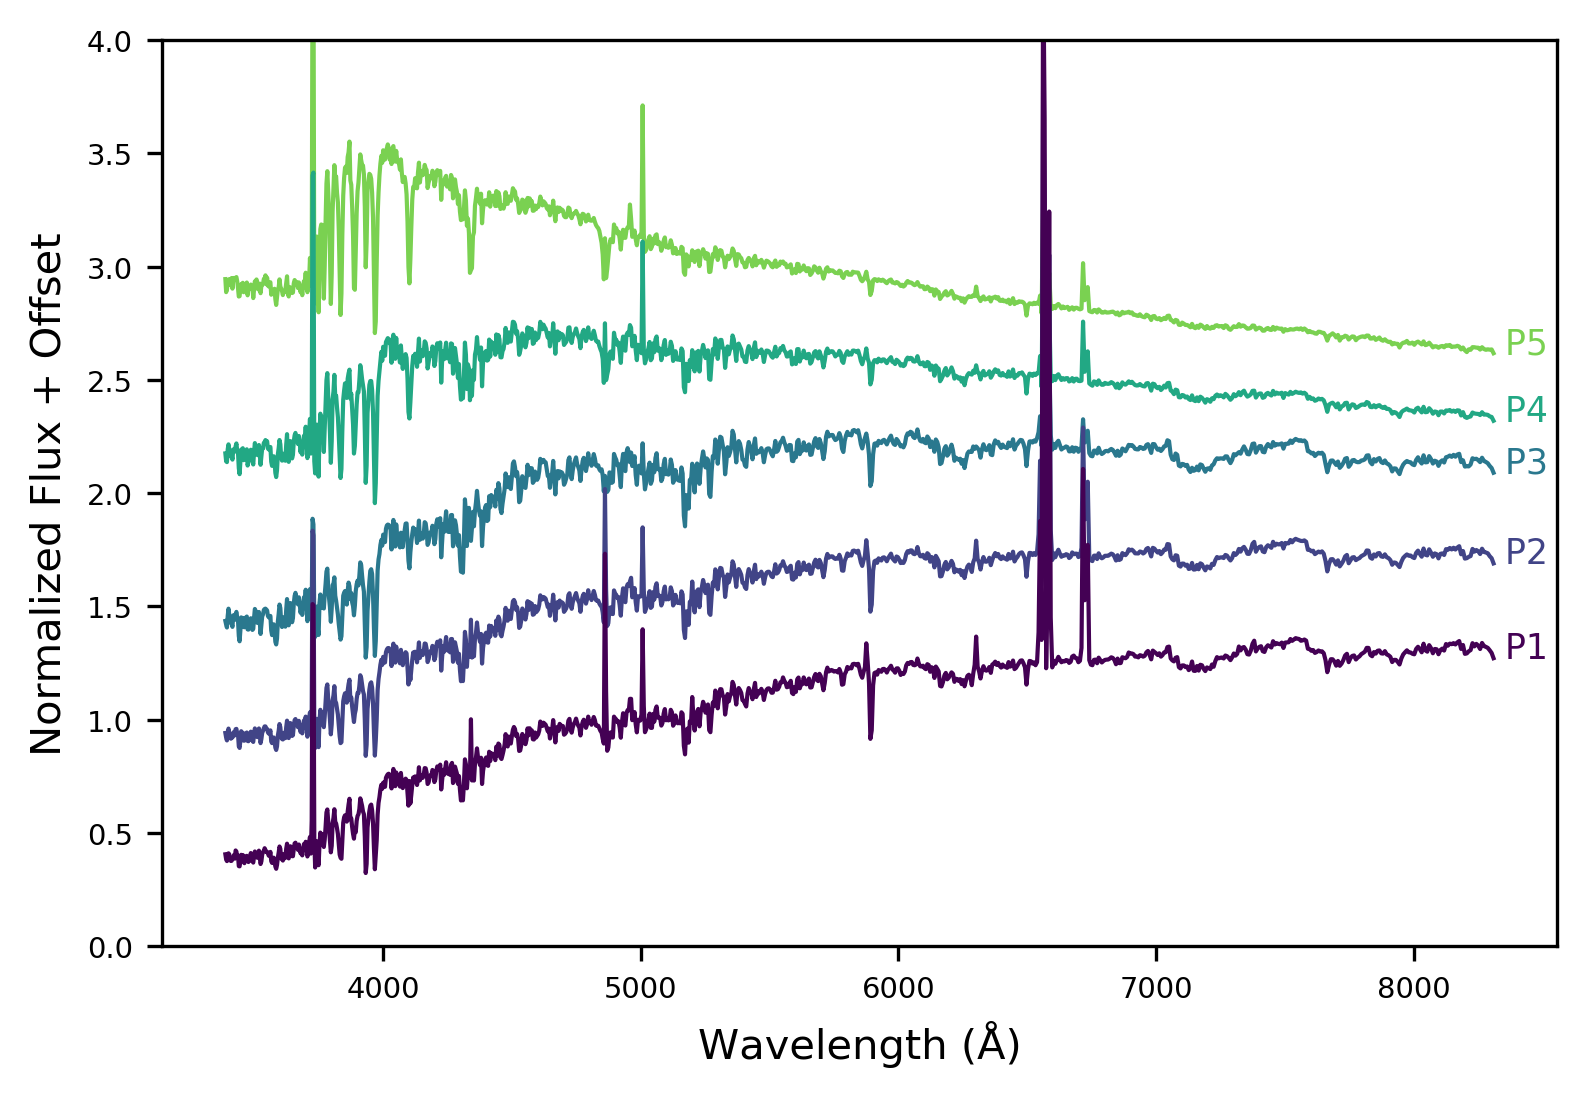

In [23]:
plot_track(coordsPSB, offset=0.5, letter='P', ymax=4)
plt.savefig('figures/PSBtrack.pdf')
plt.show()

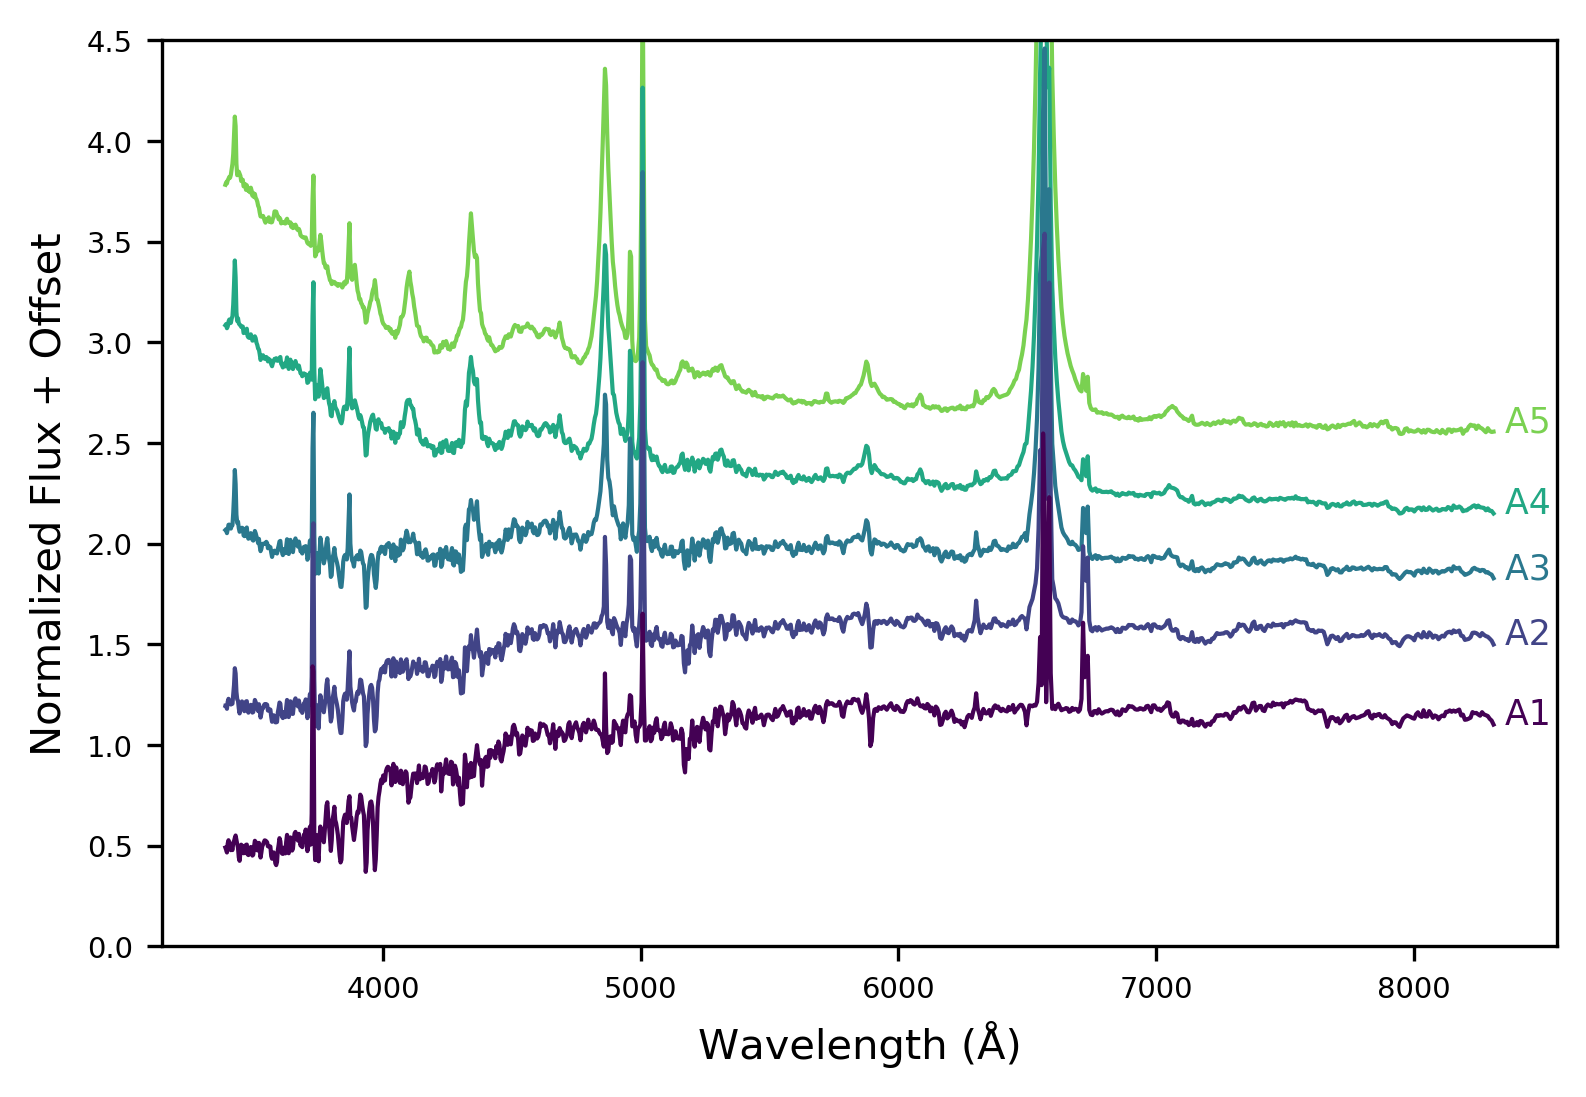

In [24]:
plot_track(coordsAGN, offset=0.5, letter='A', ymax=4.5)
plt.savefig('figures/AGNtrack.pdf')
plt.show()

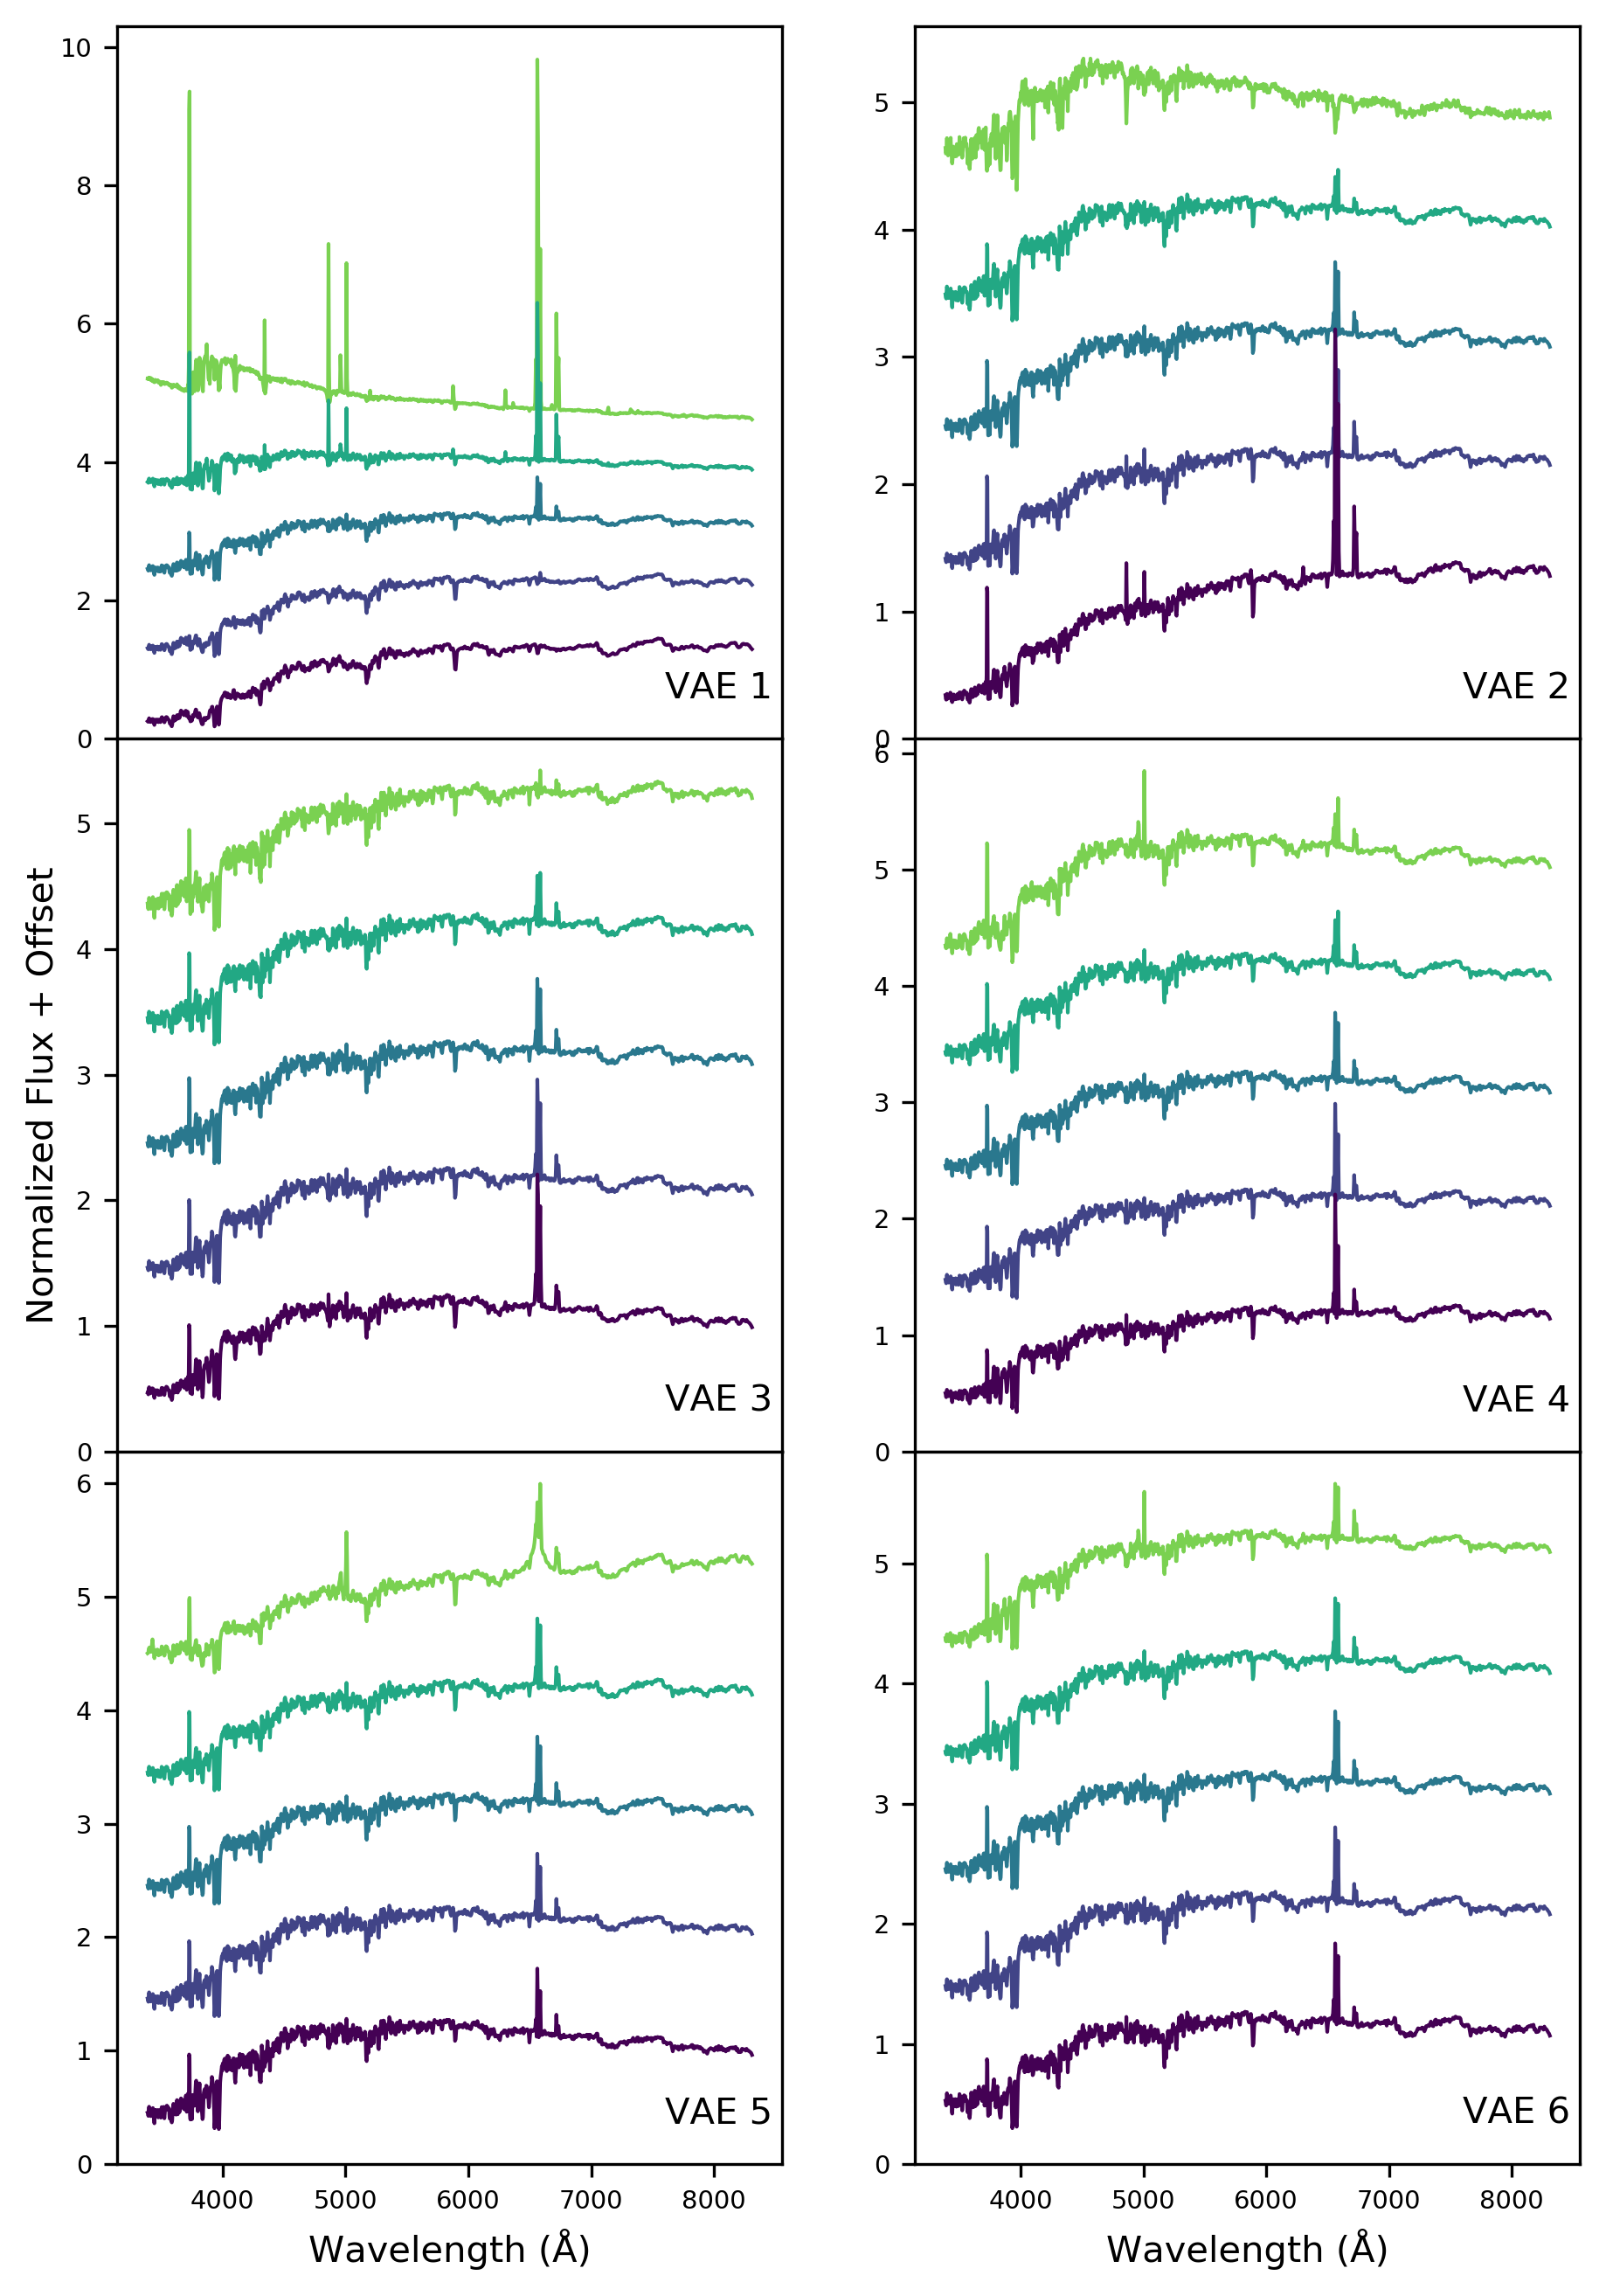

In [25]:
fig = plt.figure(figsize=(7.2, 10.8))
fig.subplots_adjust(hspace=0)
for i in range(6):
    plt.subplot(3,2,i+1)
    lower = np.percentile(latentmu_PCA[:,i], 1)
    upper = np.percentile(latentmu_PCA[:,i], 99)
    coords = np.zeros((5, model.ncode)) + np.mean(latentmu_PCA[trainidx], axis=0)
    coords[0,i] = np.percentile(latentmu_PCA[:,i], 1)
    coords[1,i] = np.percentile(latentmu_PCA[:,i], 16)
    coords[2,i] = np.mean(latentmu_PCA[:,i])
    coords[3,i] = np.percentile(latentmu_PCA[:,i], 84)
    coords[4,i] = np.percentile(latentmu_PCA[:,i], 99)
    plot_track(coords, labels=False)
    plt.annotate('VAE %i\n' % (i+1), (7600, 0))
    if i == 2:
        plt.ylabel('Normalized Flux + Offset')
    if i >= 4:
        plt.xlabel('Wavelength (Å)')
plt.savefig('figures/PCAtracks.pdf')
plt.show()

# Reconstruction Accuracy

In [26]:
npars = [2, 4, 6, 10]
models_npars = []
models_paths = ['64k_2par_20190707/0068.pth', '64k_4par_20190706/0009.pth', '64k_6par_20190704/0059.pth']
for path in models_paths:
    modelp = torch.load(path)
    modelp.eval()
    models_npars.append(modelp)
models_npars.append(model)

/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [27]:
import autoencoderv3 as AE
import tensorflow as tf

def evalAE(X, method='reconstruct', n_z=2):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        modelAE = AE.Autoencoder()
        modelAE.restore('LS_' + str(n_z))
        return modelAE.reconstruct(X)

/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/astro/users/sportill/.conda/envs/env1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/astro/users/sportill/.conda/envs/

In [28]:
train_PCA = PCA(n_components=10)
train_PCA.fit(spec[trainidx] - meanspec)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [29]:
# ensure spectra are non-negative for NMF
spec_non_neg = spec.copy()
spec_non_neg[spec_non_neg < 0] = 0

In [30]:
with torch.no_grad():
    class_sel = [None, 0, 1, 2, 3]
    
    MSE_PCA = np.zeros((len(class_sel), len(npars)))
    MSE_NMF = np.zeros((len(class_sel), len(npars)))
    MSE_VAE = np.zeros((len(class_sel), len(npars)))
    MSE_AE = np.zeros((len(class_sel), len(npars)))
    
    recon_PCA = np.zeros((len(npars), spec[valididx].shape[0], spec[valididx].shape[1]))
    recon_VAE = np.zeros((len(npars), spec[valididx].shape[0], spec[valididx].shape[1]))
    recon_NMF = np.zeros((len(npars), spec[valididx].shape[0], spec[valididx].shape[1]))
    recon_AE = np.zeros((len(npars), spec[valididx].shape[0], spec[valididx].shape[1]))
    
    specPCA = train_PCA.transform(spec[valididx] - meanspec)
    
    for i in range(len(npars)):
        specPCAtemp = specPCA.copy()
        specPCAtemp[:,npars[i]:] = 0
        recon_PCA[i,:,:] = train_PCA.inverse_transform(specPCAtemp) + meanspec
        
        train_NMF = NMF(n_components=npars[i])
        train_NMF.fit(spec_non_neg[trainidx])
        recon_NMF[i,:,:] = train_NMF.inverse_transform(train_NMF.transform(spec_non_neg[valididx]))
        
        recon_AE[i,:,:] = evalAE(spec[valididx], method='reconstruct', n_z=npars[i])
        
        modeli = models_npars[i]
        _, mu_batch, _ = modeli(torch.tensor(spec[valididx] - meanspec, dtype=torch.float32)) # keep latent means
        recon_VAE[i,:,:] = modeli.decode(mu_batch).numpy() + meanspec
        for j, sel in enumerate(class_sel):
            if sel is None:
                mask = np.full((specclass[valididx].size), True, dtype=np.bool)
            else:
                mask = (specclass[valididx] == sel)
            MSE_PCA[j,i] = np.mean(spec_weig[valididx][mask] * (recon_PCA[i,mask,:] - spec[valididx][mask,:])**2)
            MSE_VAE[j,i] = np.mean(spec_weig[valididx][mask] * (recon_VAE[i,mask,:] - spec[valididx][mask,:])**2)
            MSE_NMF[j,i] = np.mean(spec_weig[valididx][mask] * (recon_NMF[i,mask,:] - spec[valididx][mask,:])**2)
            MSE_AE[j,i] = np.mean(spec_weig[valididx][mask] * (recon_AE[i,mask,:] - spec[valididx][mask,:])**2)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from temp/LS_2/model.ckpt
Model restored.
INFO:tensorflow:Restoring parameters from temp/LS_4/model.ckpt
Model restored.
INFO:tensorflow:Restoring parameters from temp/LS_6/model.ckpt
Model restored.
INFO:tensorflow:Restoring parameters from temp/LS_10/model.ckpt
Model restored.


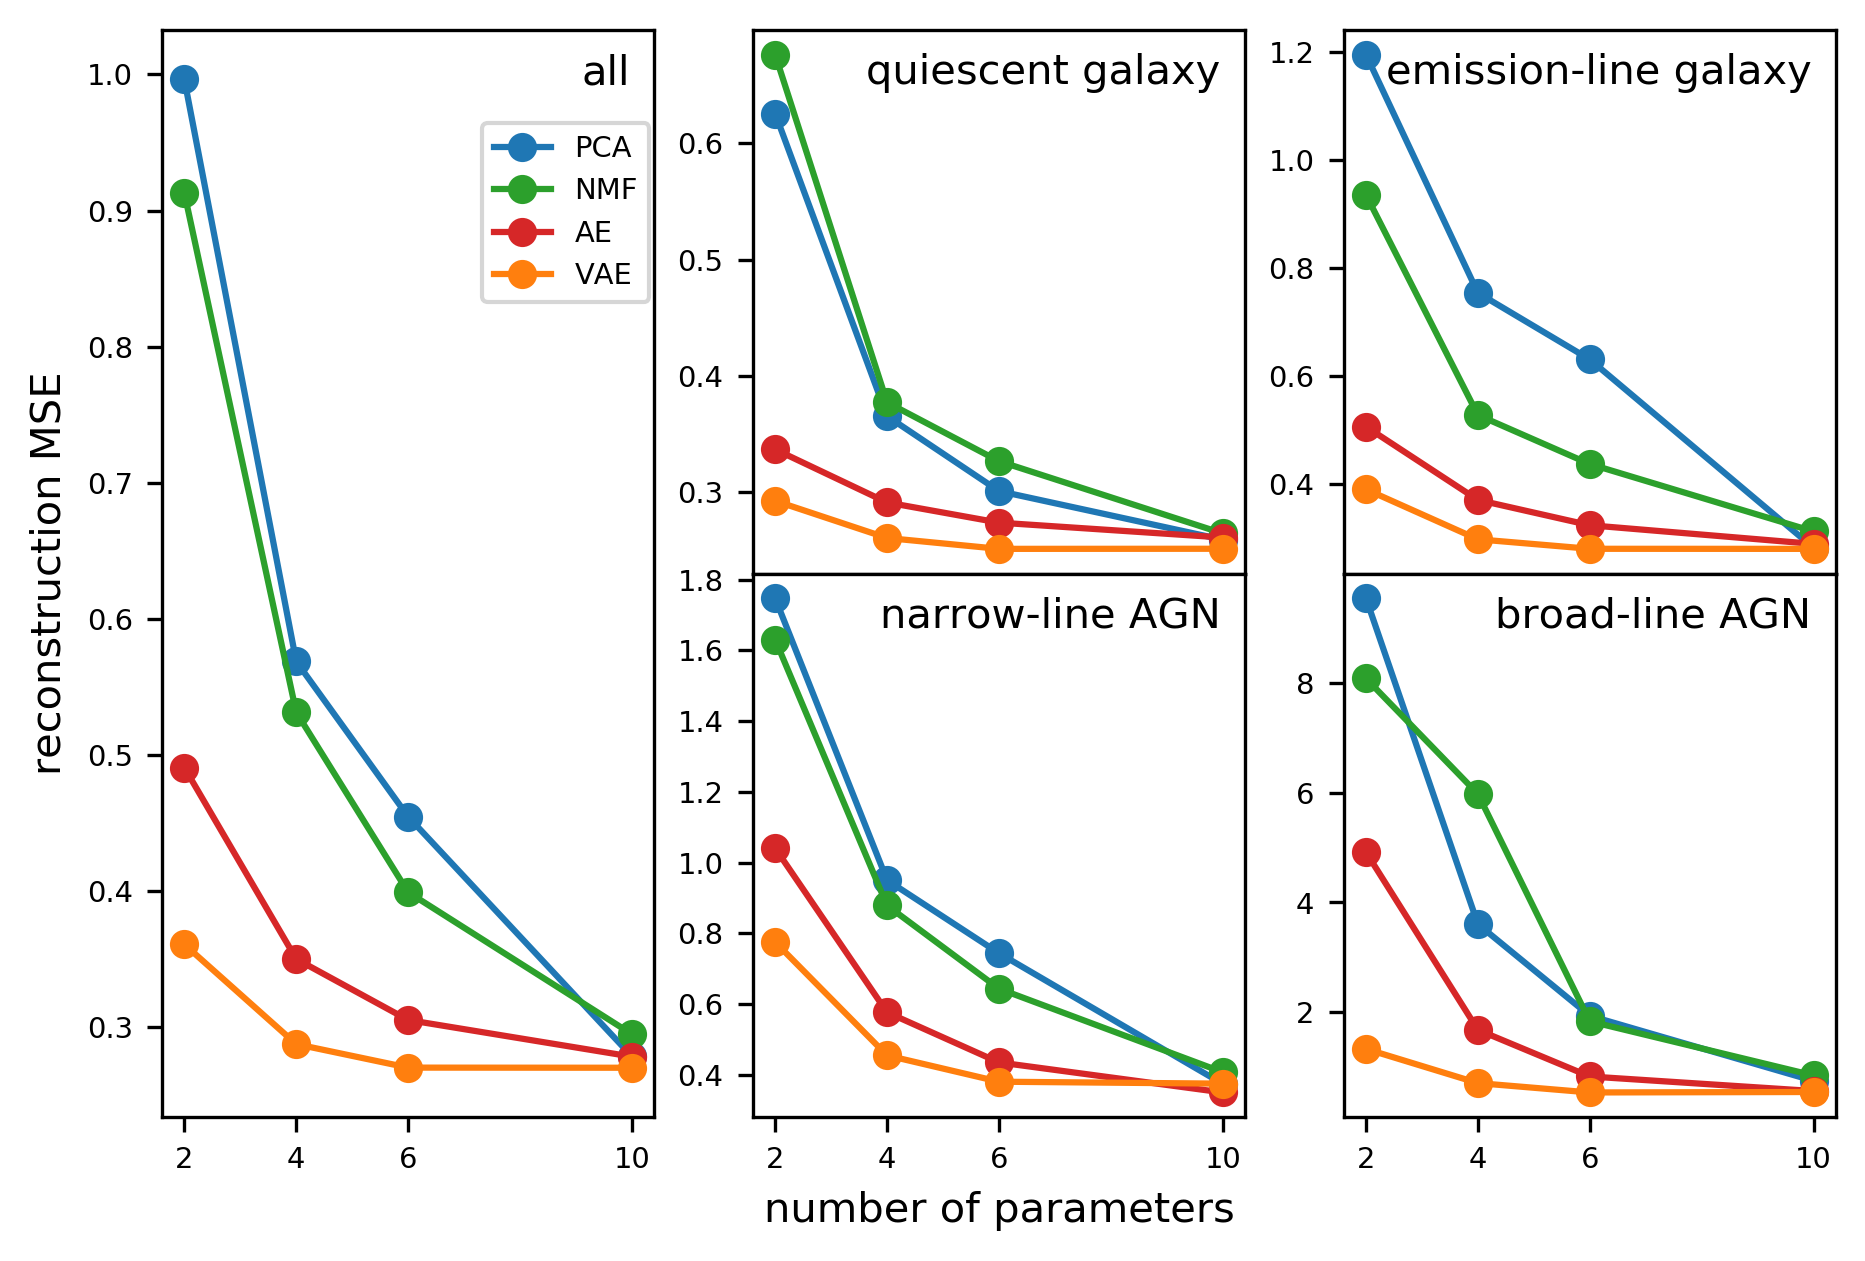

In [31]:
fig = plt.figure(figsize=(7.2, 4.8))
gs = fig.add_gridspec(2, 3)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for j, sel in enumerate(class_sel):
    if sel is not None:
        classname = specclassnames[sel]
    else:
        classname = "all"
    if j == 0:
        ax = fig.add_subplot(gs[:,0])
    else:
        ax = fig.add_subplot(gs[(j-1)//2,(j-1)%2+1])
    ax.plot(npars, MSE_PCA[j,:], 'o-', label='PCA', c=colors[0])
    ax.plot(npars, MSE_NMF[j,:], 'o-', label='NMF', c=colors[2])
    ax.plot(npars, MSE_AE[j,:], 'o-', label='AE', c=colors[3])
    ax.plot(npars, MSE_VAE[j,:], 'o-', label='VAE', c=colors[1])

    if j == 0:
        ax.legend(loc=(0.65,0.75))
        ax.set_ylabel('reconstruction MSE')
    if j == 0 or (j-1)//2 == 1:
        ax.set_xticks(npars)
    if j == 3:
        ax.set_xlabel('number of parameters')
    ax.text(0.95,0.9 + (0.05)*(j==0),classname,transform=ax.transAxes,horizontalalignment='right')
fig.subplots_adjust(hspace=0)
plt.savefig('figures/recon.pdf')
plt.show()

# Zoom in on some reconstructions

In [32]:
def zoomin(specidx, wavelengths, npix=20, tag=''):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    thisspec = spec[valididx[specidx], :].copy()
    thisspec[spec_mask[valididx[specidx]]] = float('nan')
    specstd = spec_err[valididx[specidx]]
    
    thisPCA = recon_PCA[:,specidx,:].copy()
    
    thisVAE = recon_VAE[:,specidx,:].copy()    
    
    print('spectrum', plate_mjd_fiber[valididx[specidx]])
    print('median SNR overall', np.nanmedian(thisspec / specstd))
    for wavelength in wavelengths:
        k = np.where(lam > wavelength)[0][0]
        ylim_l = np.nanmin(thisspec[k-npix:k+npix]) *.9
        ylim_u = np.nanmax(thisspec[k-npix:k+npix]) *1.1
        
        ylim_resid = max(np.nanmax(np.abs(thisPCA[:,k-npix:k+npix] - thisspec[k-npix:k+npix])/specstd[k-npix:k+npix]),
                         np.nanmax(np.abs(thisVAE[:,k-npix:k+npix] - thisspec[k-npix:k+npix])/specstd[k-npix:k+npix])) * 1.1
        
        fig, axes = plt.subplots(3, len(npars), sharex=True, sharey='row',figsize=(7.2,5.4))
        fig.subplots_adjust(hspace=0, wspace=0)
        for i, j in enumerate(npars):
            ax = axes[0, i]
            ax.plot(lam[k-npix:k+npix], thisspec[k-npix:k+npix], 'k', label='data')
            ax.plot(lam[k-npix:k+npix], thisPCA[i,k-npix:k+npix], c=colors[0], label='PCA recon')
            ax.set_title('%i parameters' % (j))
            if i == 0:
                ax.legend(handlelength=1, fontsize='xx-small')
                ax.set_ylabel('Flux (arb. units)')
            ax.set_ylim(ylim_l, ylim_u)
            ax = axes[1, i]
            ax.plot(lam[k-npix:k+npix], thisspec[k-npix:k+npix], 'k', label='data')
            ax.plot(lam[k-npix:k+npix], thisVAE[i,k-npix:k+npix], c=colors[1], label='VAE recon')

            if i == 0:
                ax.legend(handlelength=1, fontsize='xx-small')
                ax.set_ylabel('Flux (arb. units)')
            ax.set_ylim(ylim_l, ylim_u)
            ax = axes[2, i]
            
            ax.fill_between(lam[k-npix:k+npix], -1, 1, facecolor='grey', label='noise')
            ax.plot(lam[k-npix:k+npix], (thisPCA[i,k-npix:k+npix] - thisspec[k-npix:k+npix])/specstd[k-npix:k+npix], c=colors[0], label='PCA resid')
            ax.plot(lam[k-npix:k+npix], (thisVAE[i,k-npix:k+npix] - thisspec[k-npix:k+npix])/specstd[k-npix:k+npix], c=colors[1], label='VAE resid')
            ax.set_ylim(-ylim_resid, ylim_resid)
            if i == 0:
                ax.legend(handlelength=1, fontsize='xx-small')
                ax.set_ylabel('significance (σ)')
            ax.set_xlabel('Wavelength (Å)')
        print('median SNR in window', np.nanmedian(thisspec[k-npix:k+npix] / specstd[k-npix:k+npix]))
        plt.savefig('figures/'+tag+('_%i' % (wavelength))+'.pdf')
        plt.show()

spectrum [  541 51959   519]
median SNR overall 27.781125969294866
median SNR in window 30.195931673302955


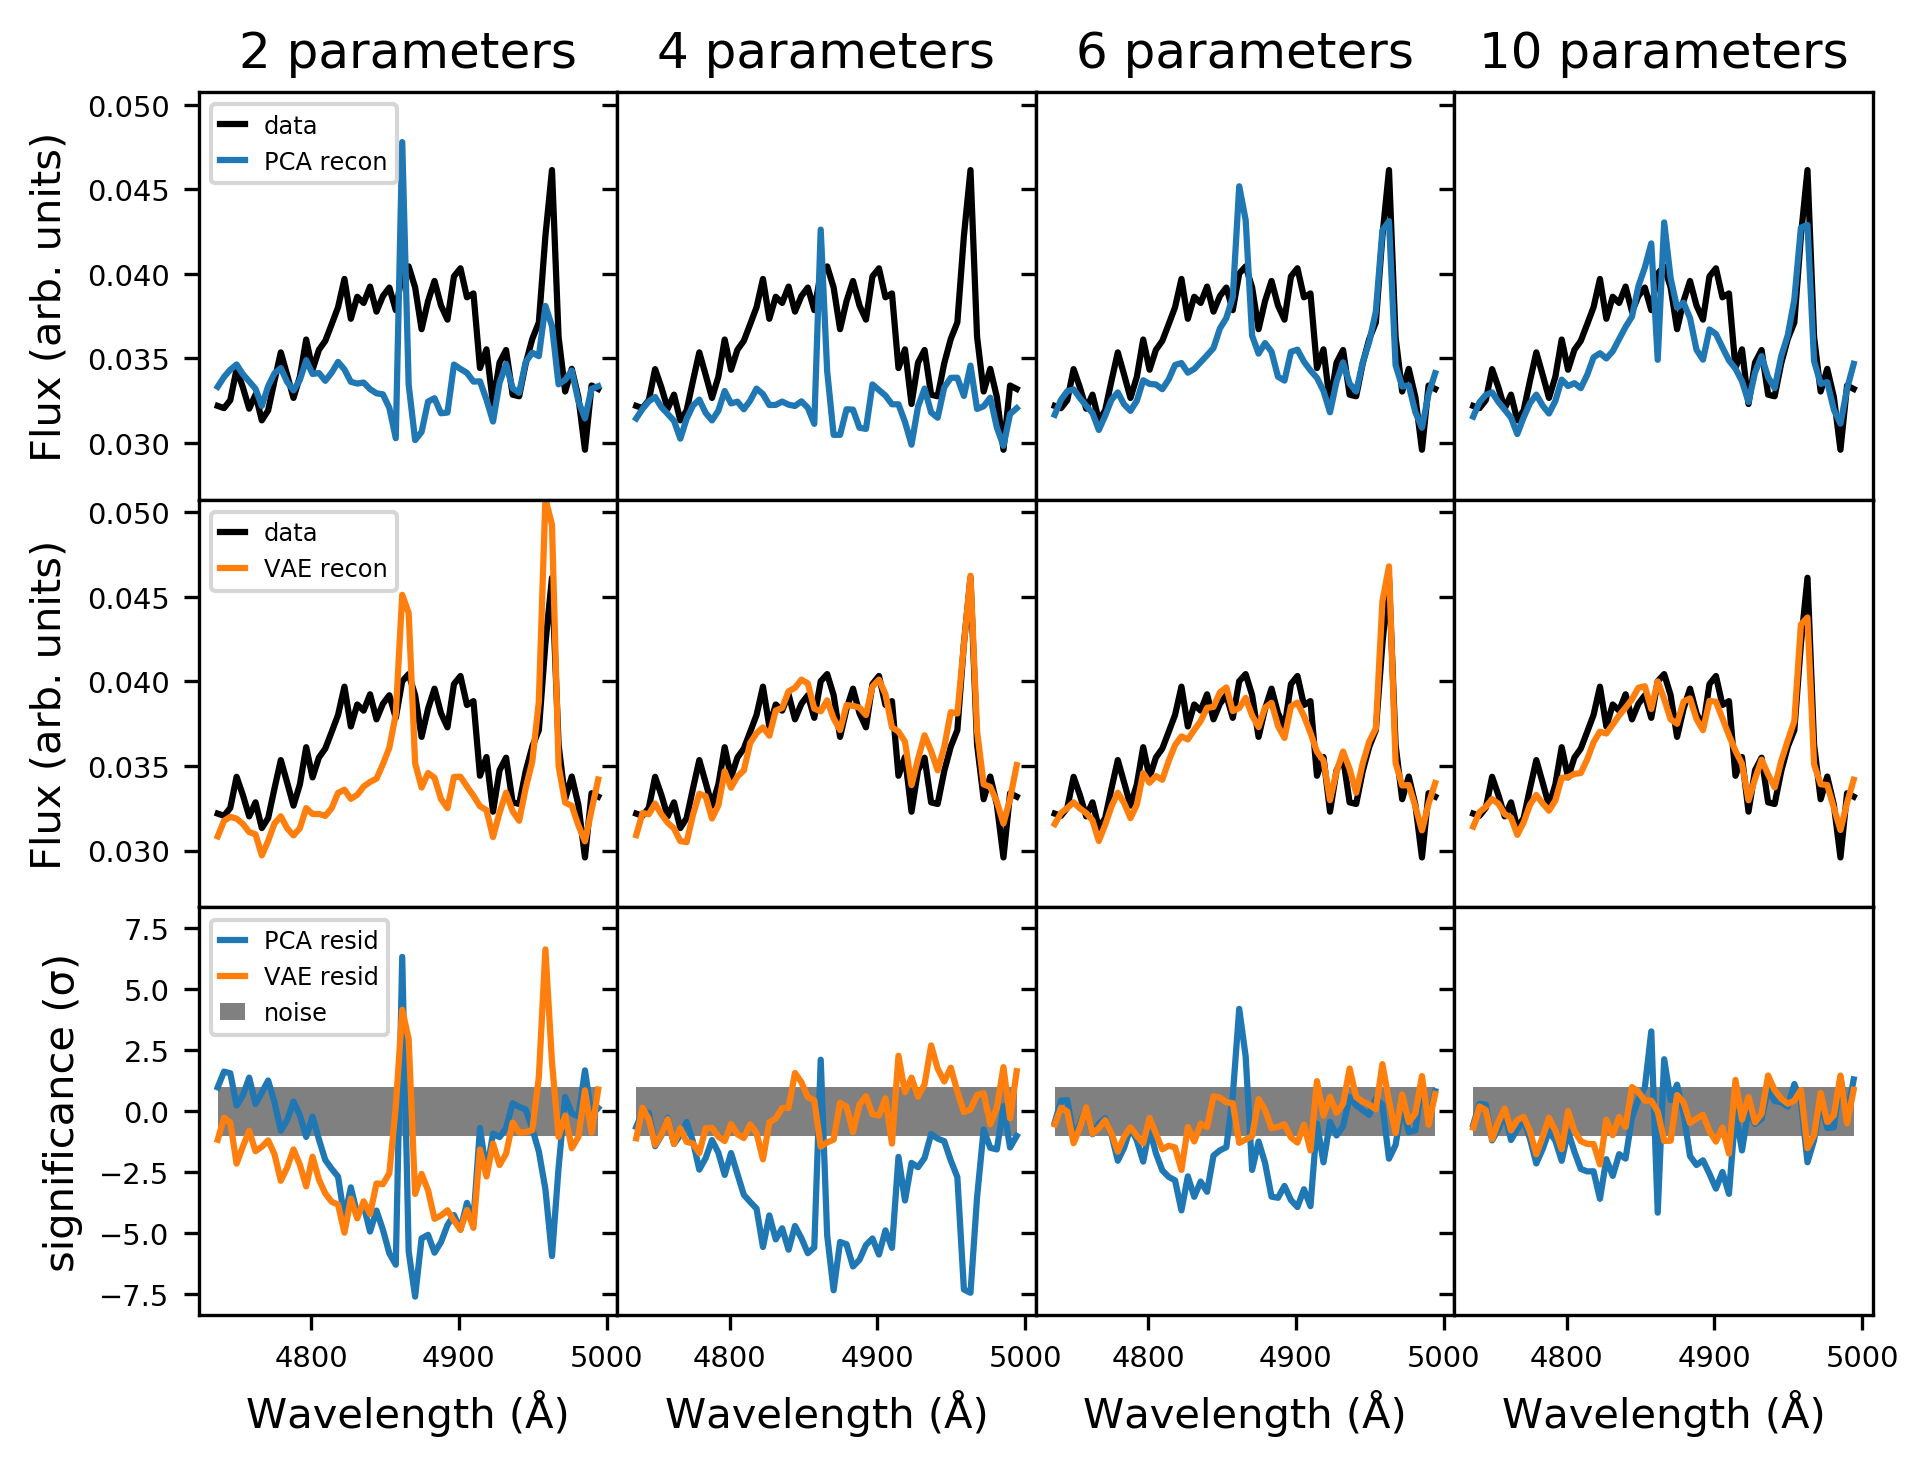

median SNR in window 47.430575269899435


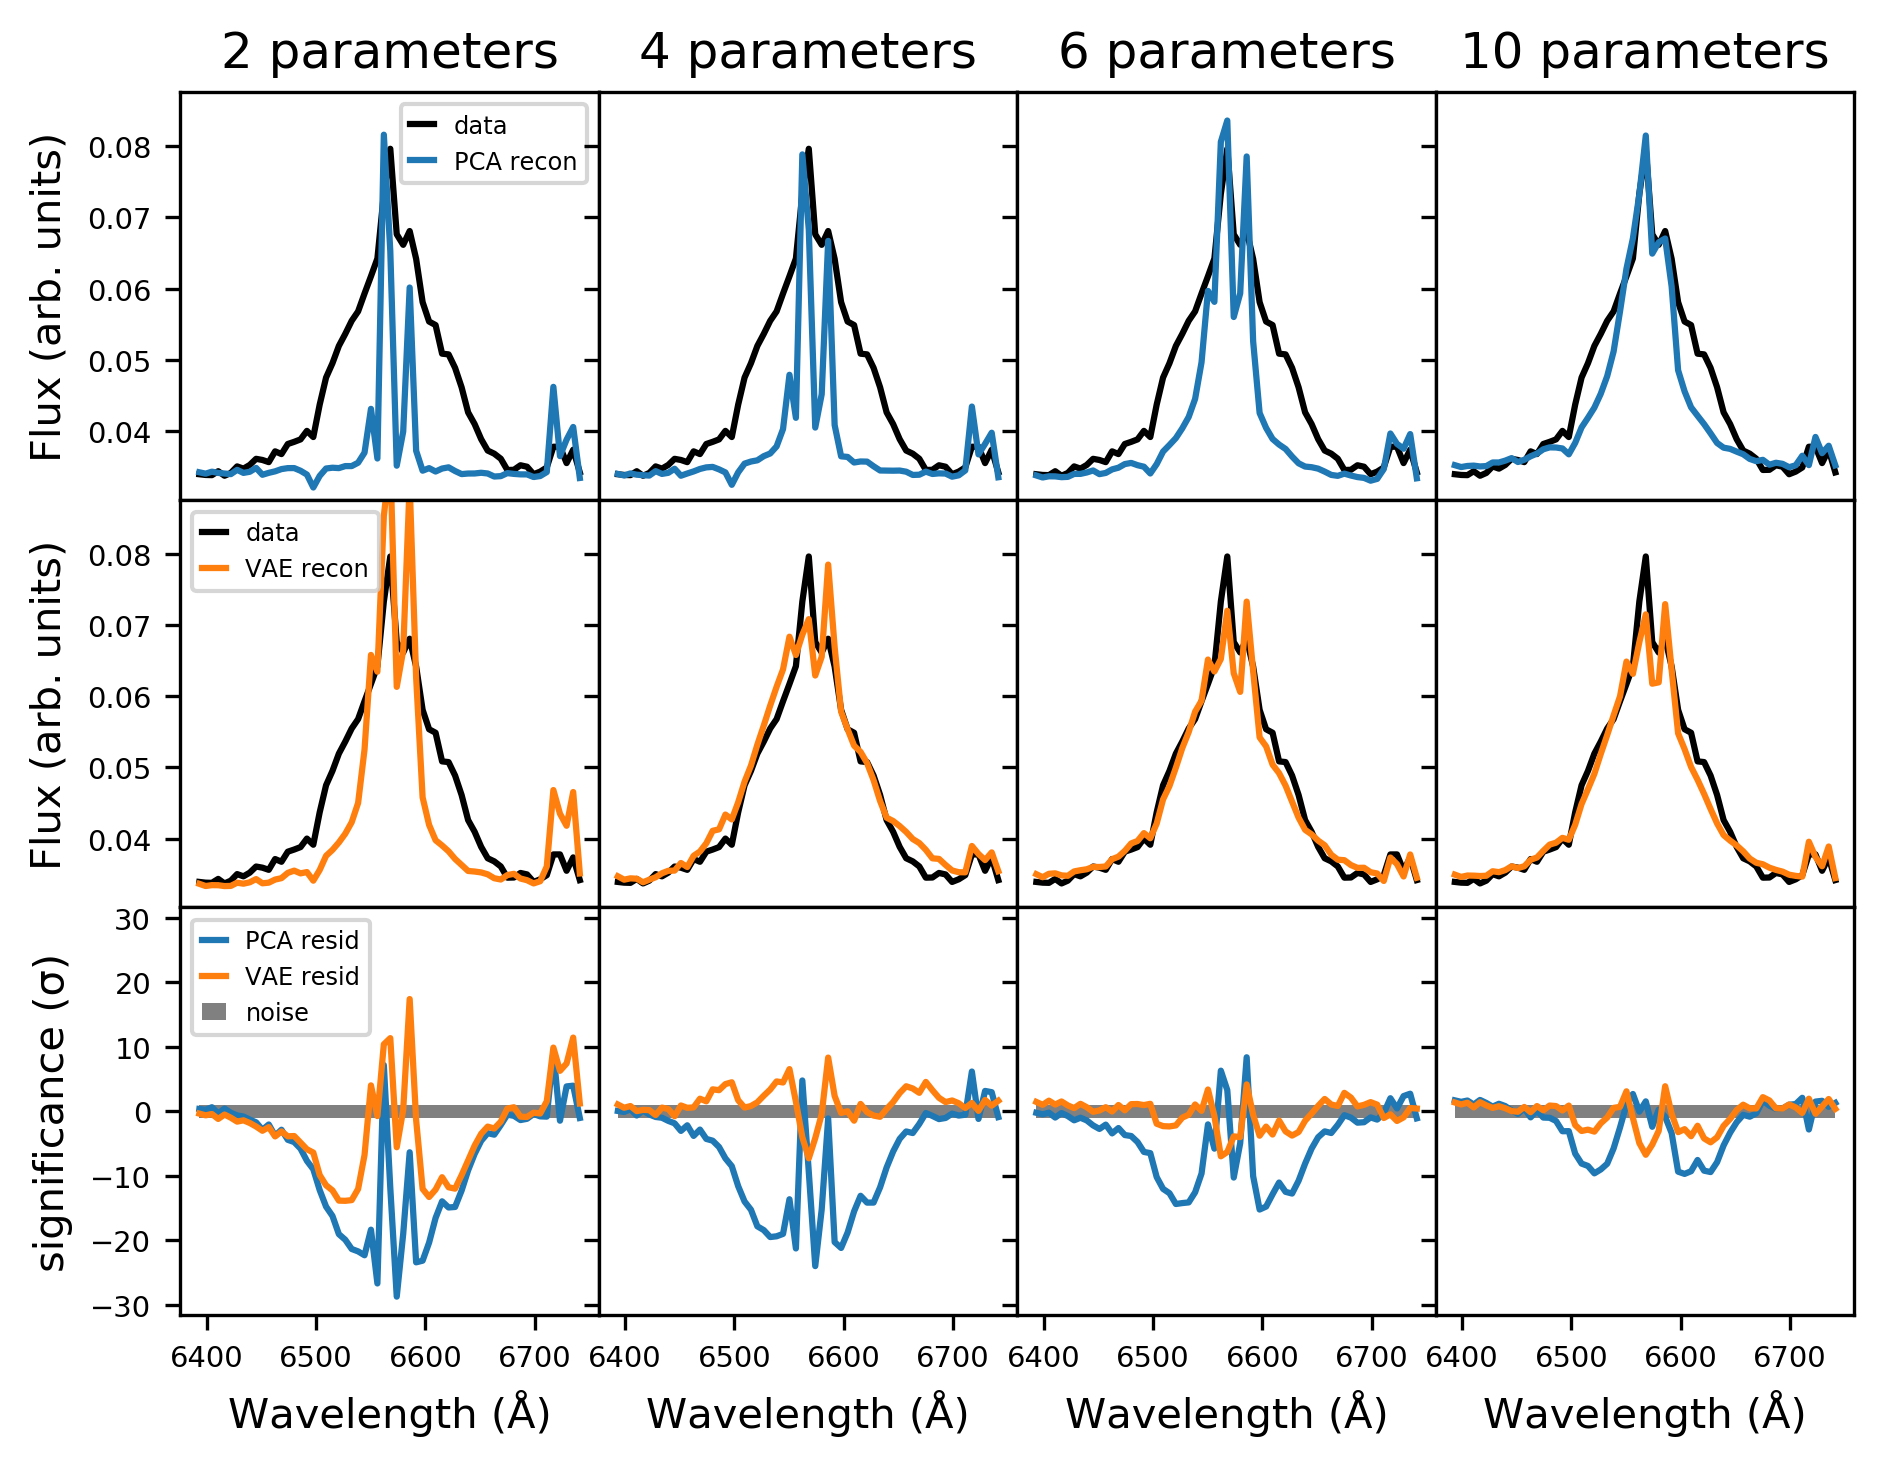

In [33]:
zoomin(12, [4863, 6565], npix=30, tag='BL')

spectrum [  391 51782   239]
median SNR overall 27.141957746168956
median SNR in window 8.069001746229482


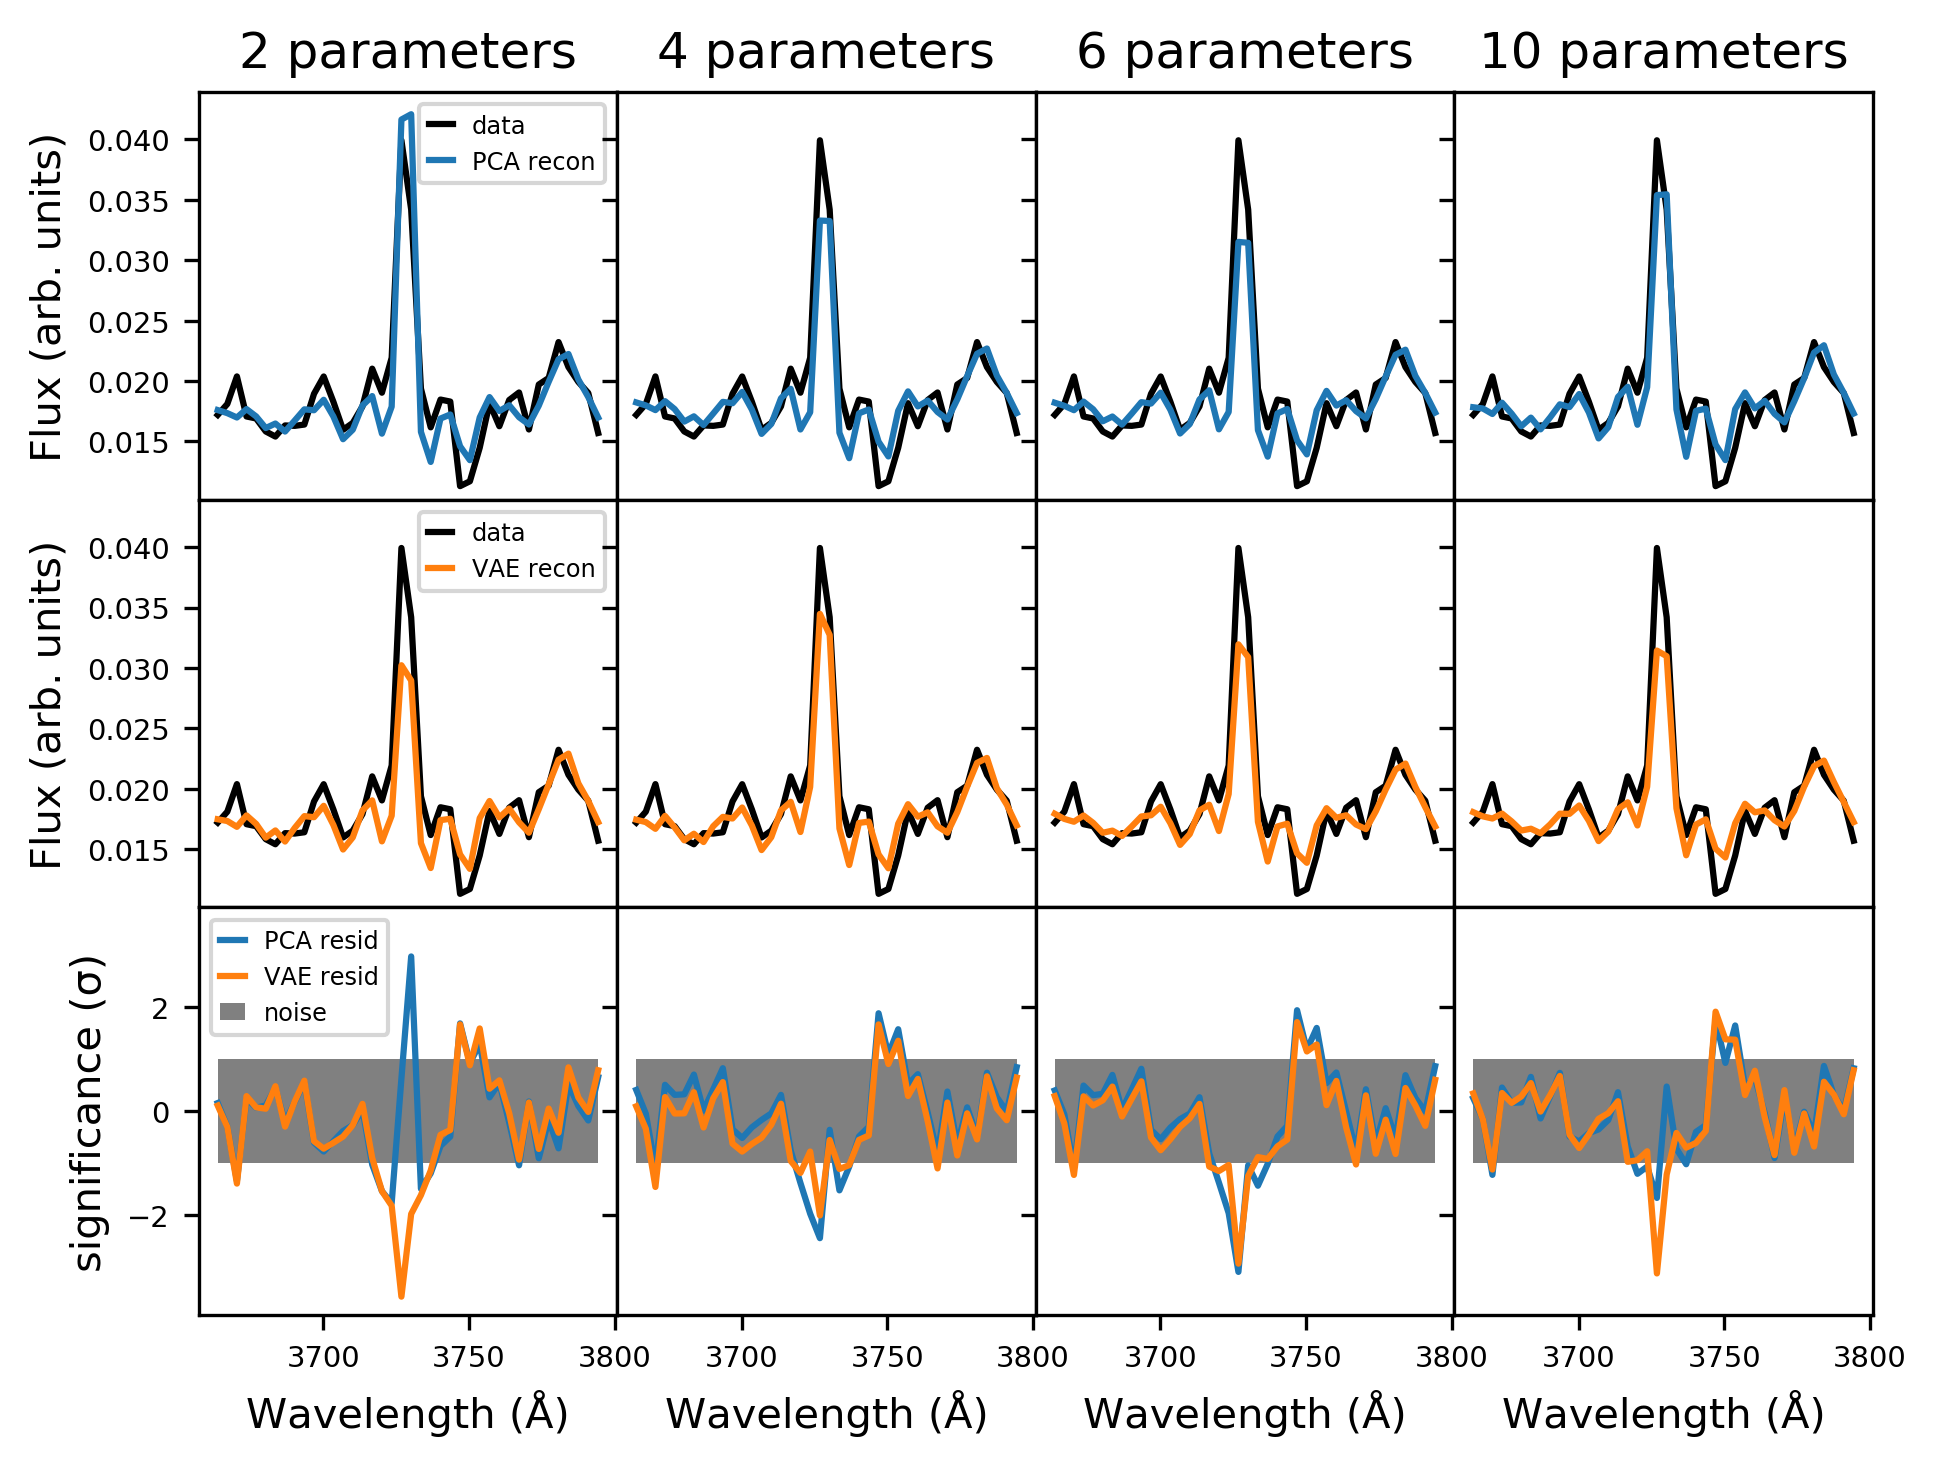

median SNR in window 37.381985766697596


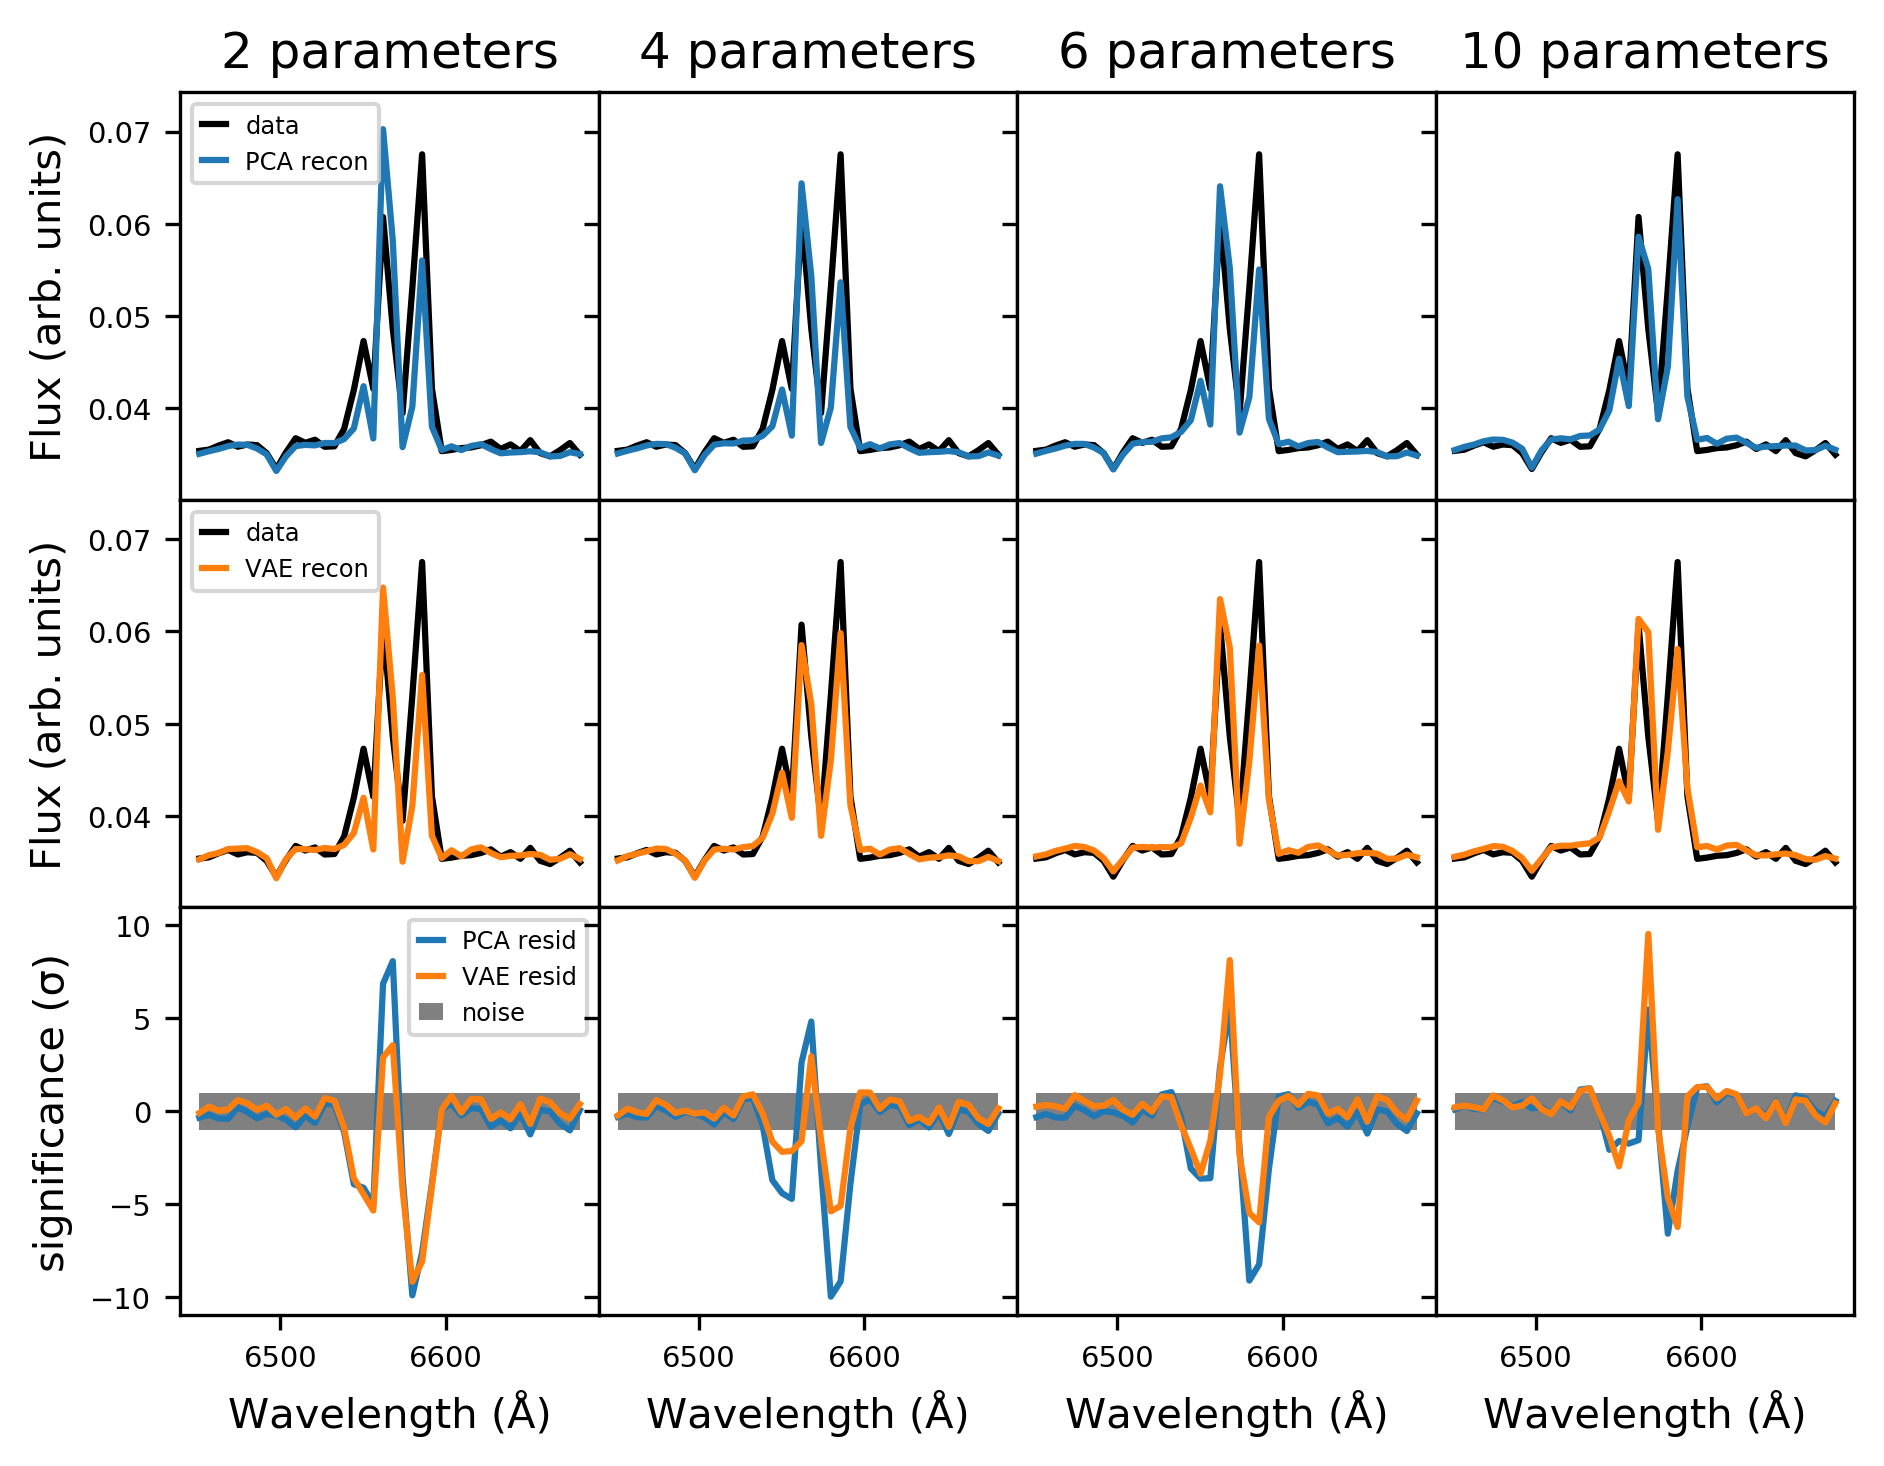

In [34]:
zoomin(2670, [3727, 6565], tag='EL')

spectrum [  394 51913   561]
median SNR overall 81.89184328181535
median SNR in window 96.95832196274404


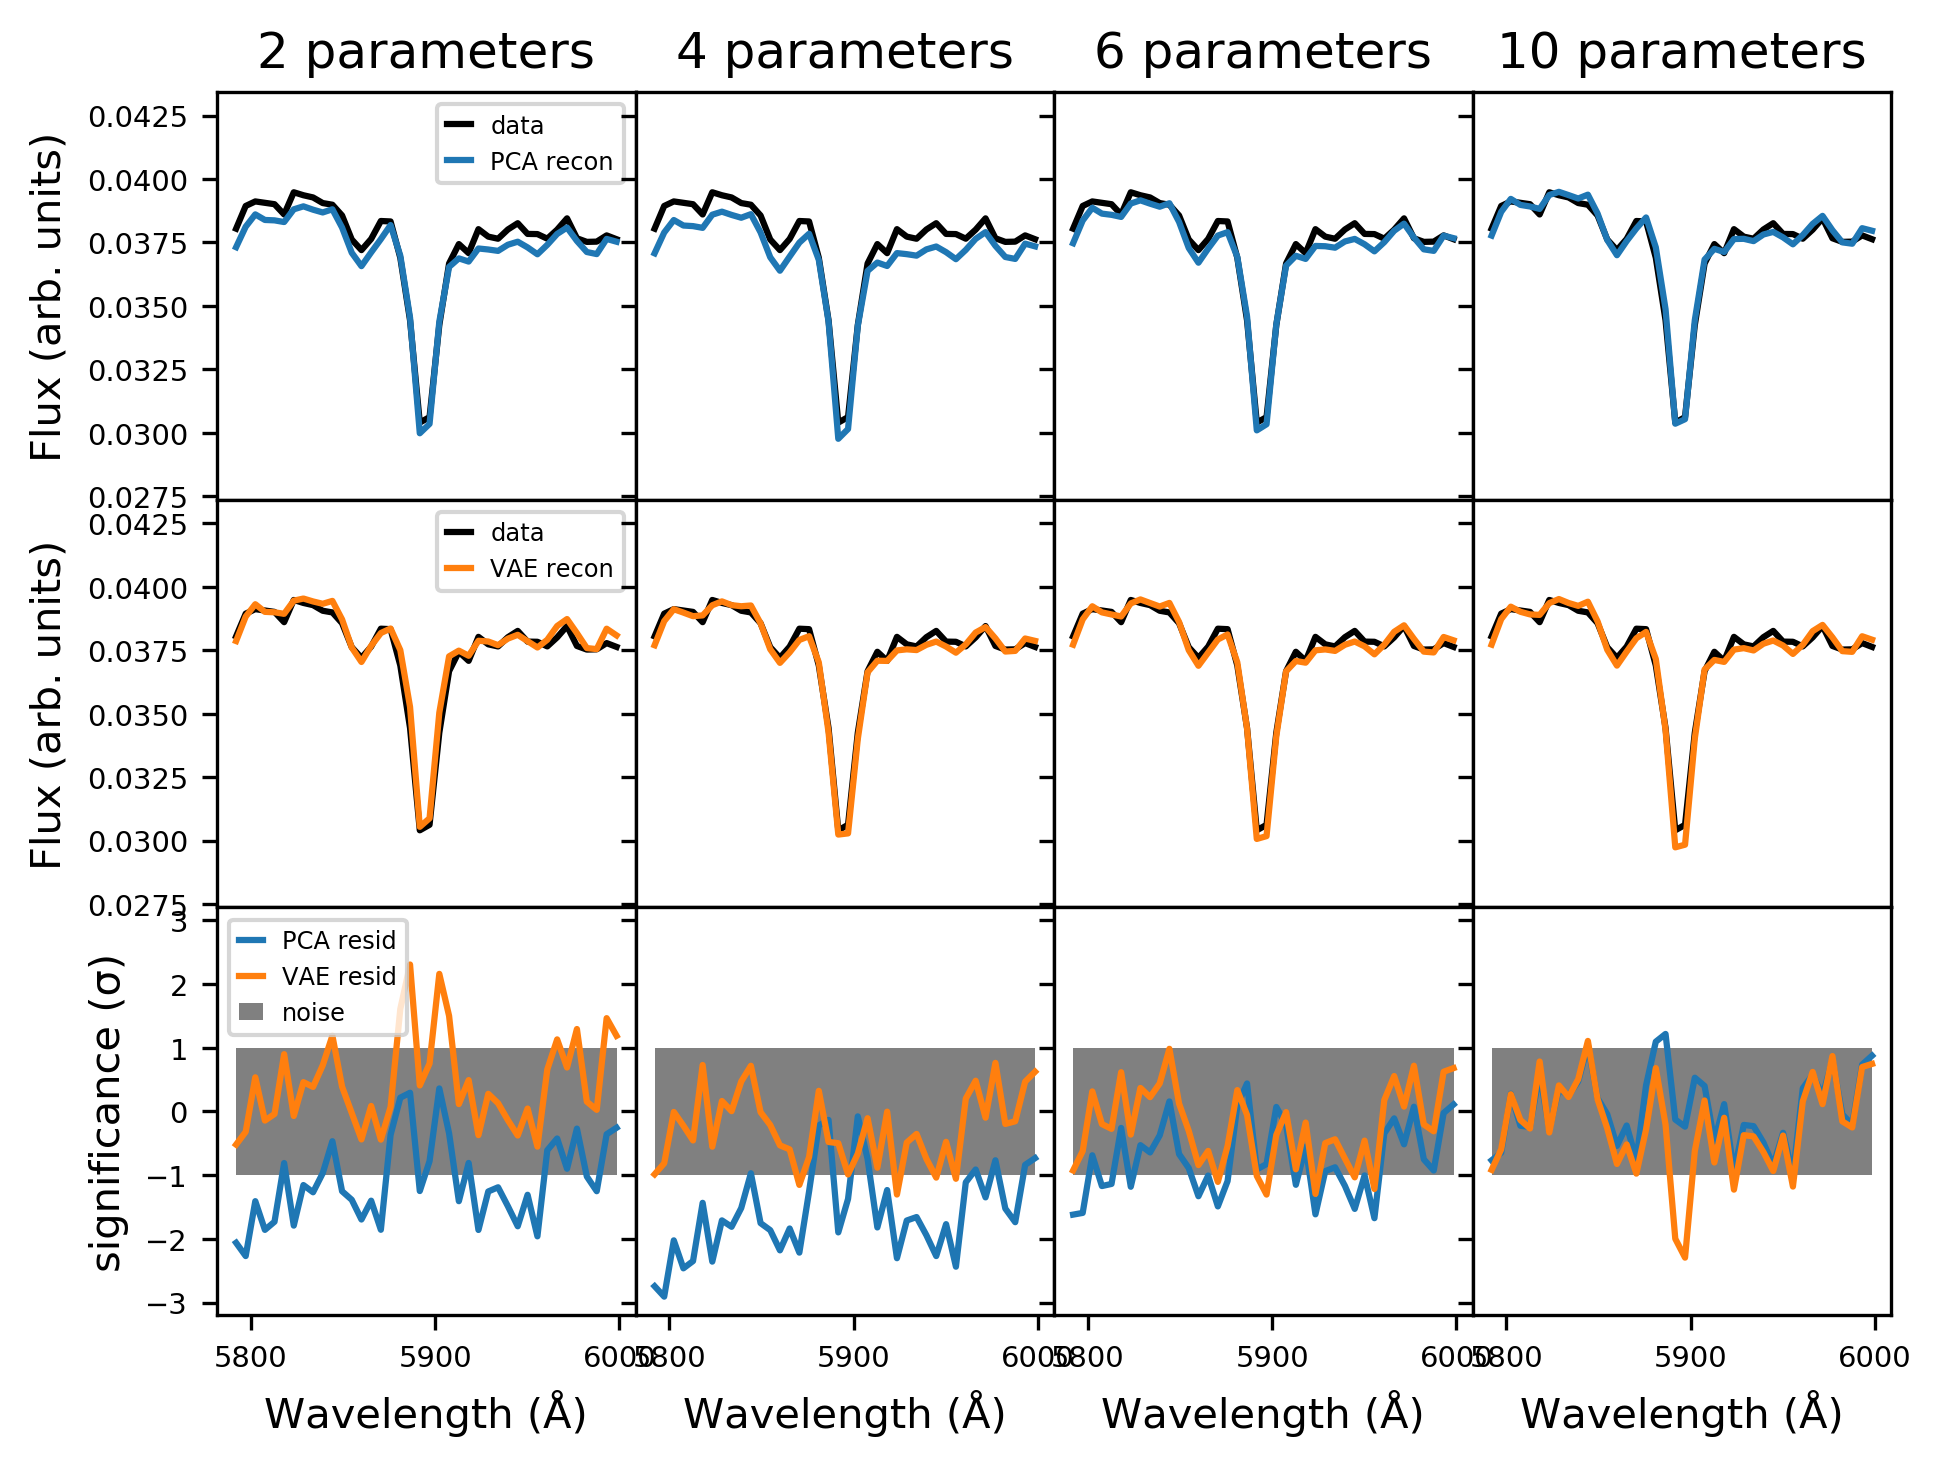

median SNR in window 102.30210218226361


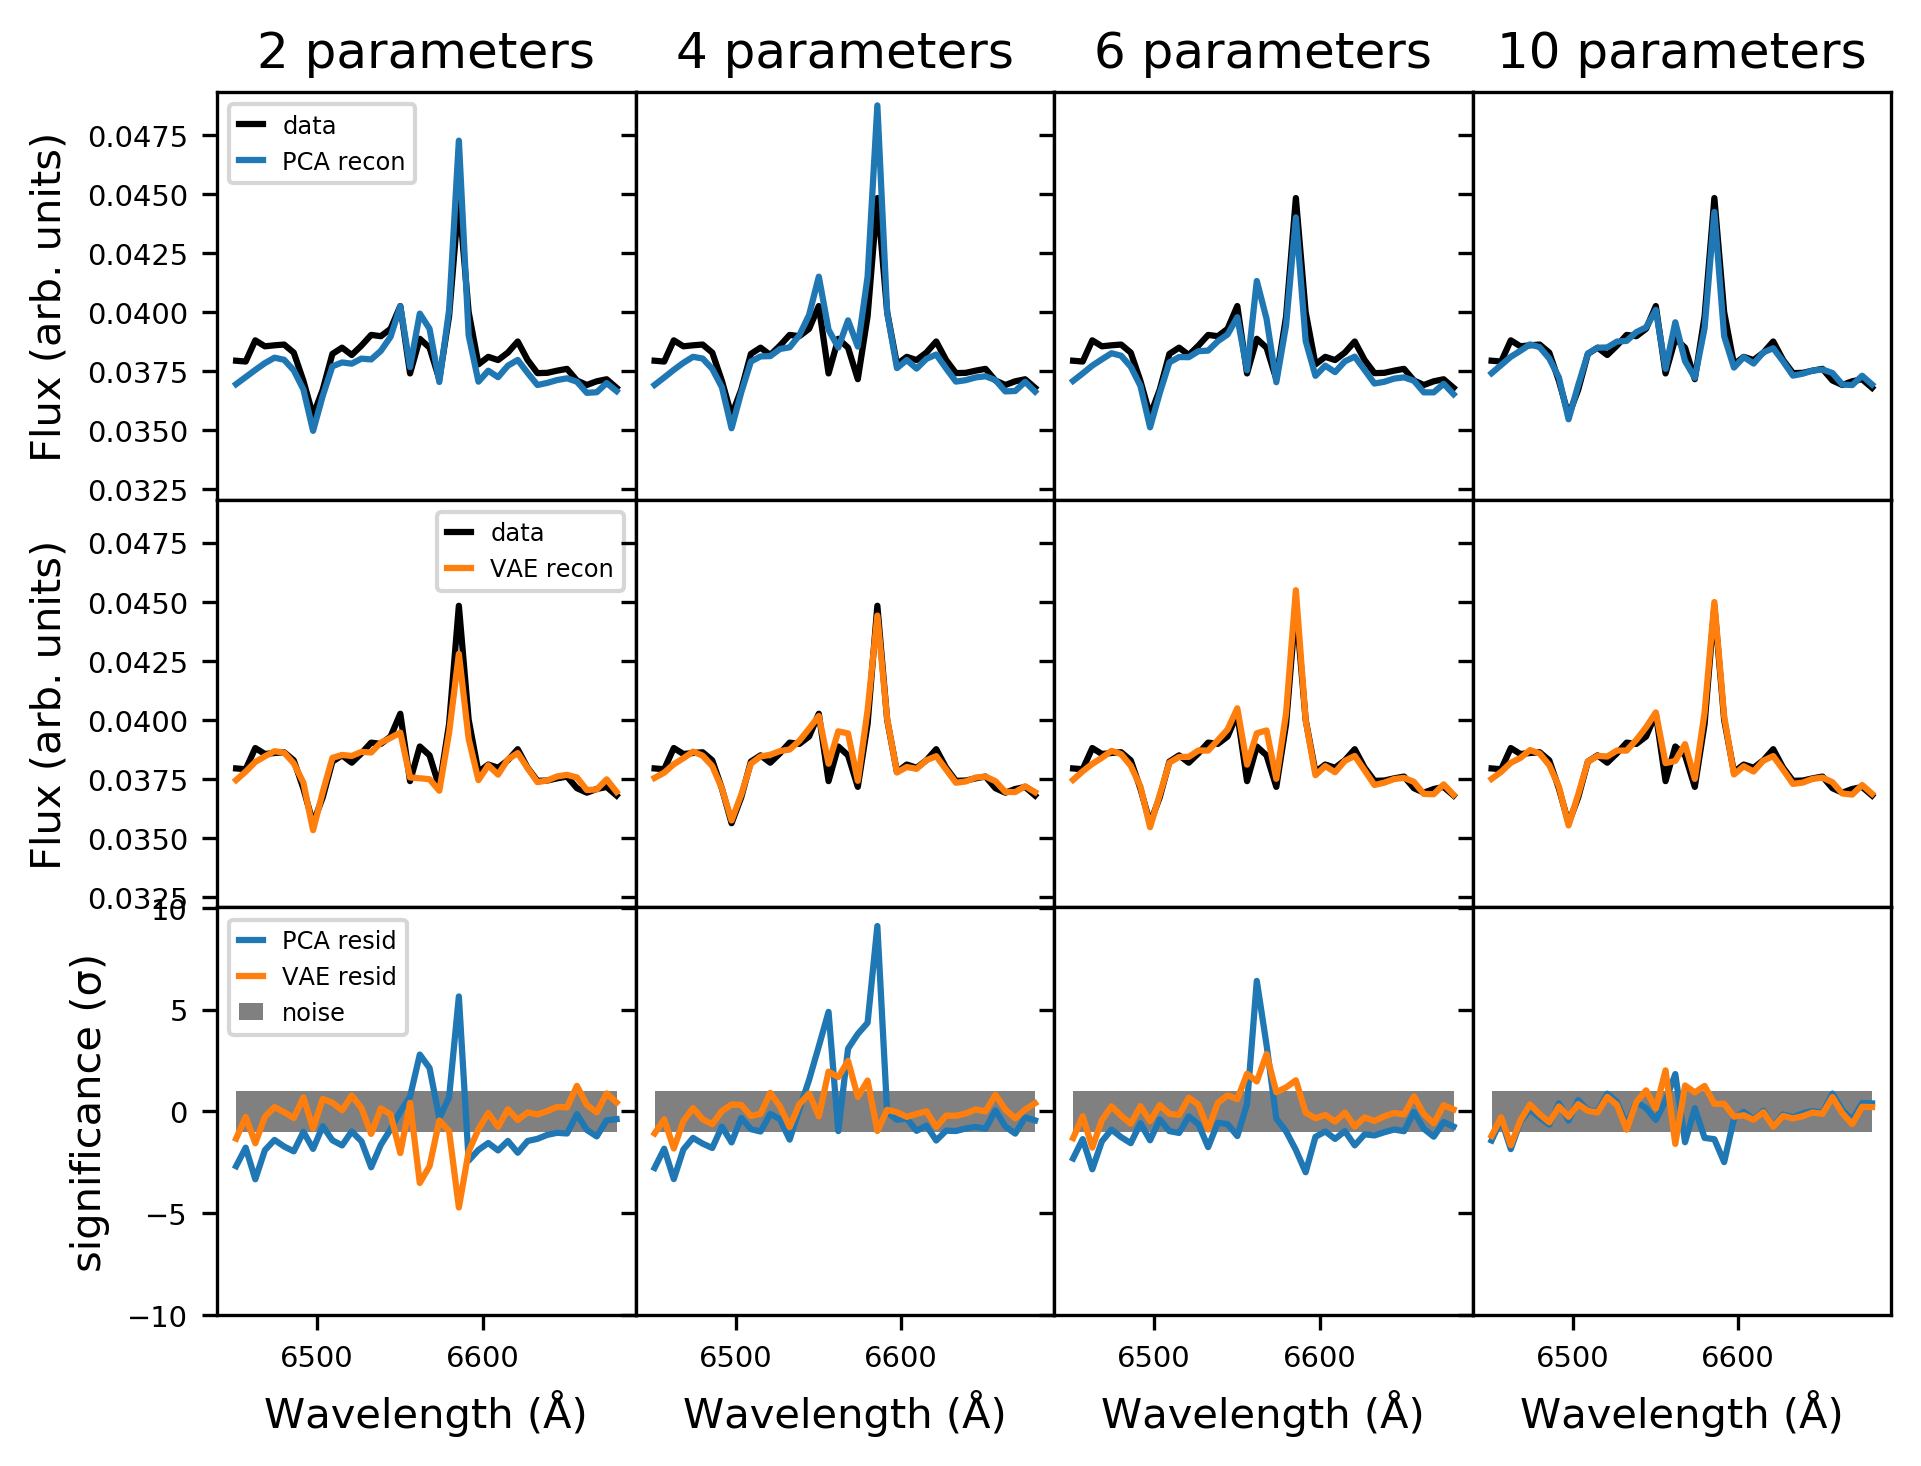

In [35]:
zoomin(6884, [5896, 6565], tag='hiSNR')

spectrum [  497 51989   573]
median SNR overall 11.478848313849168
median SNR in window 20.319432492063363


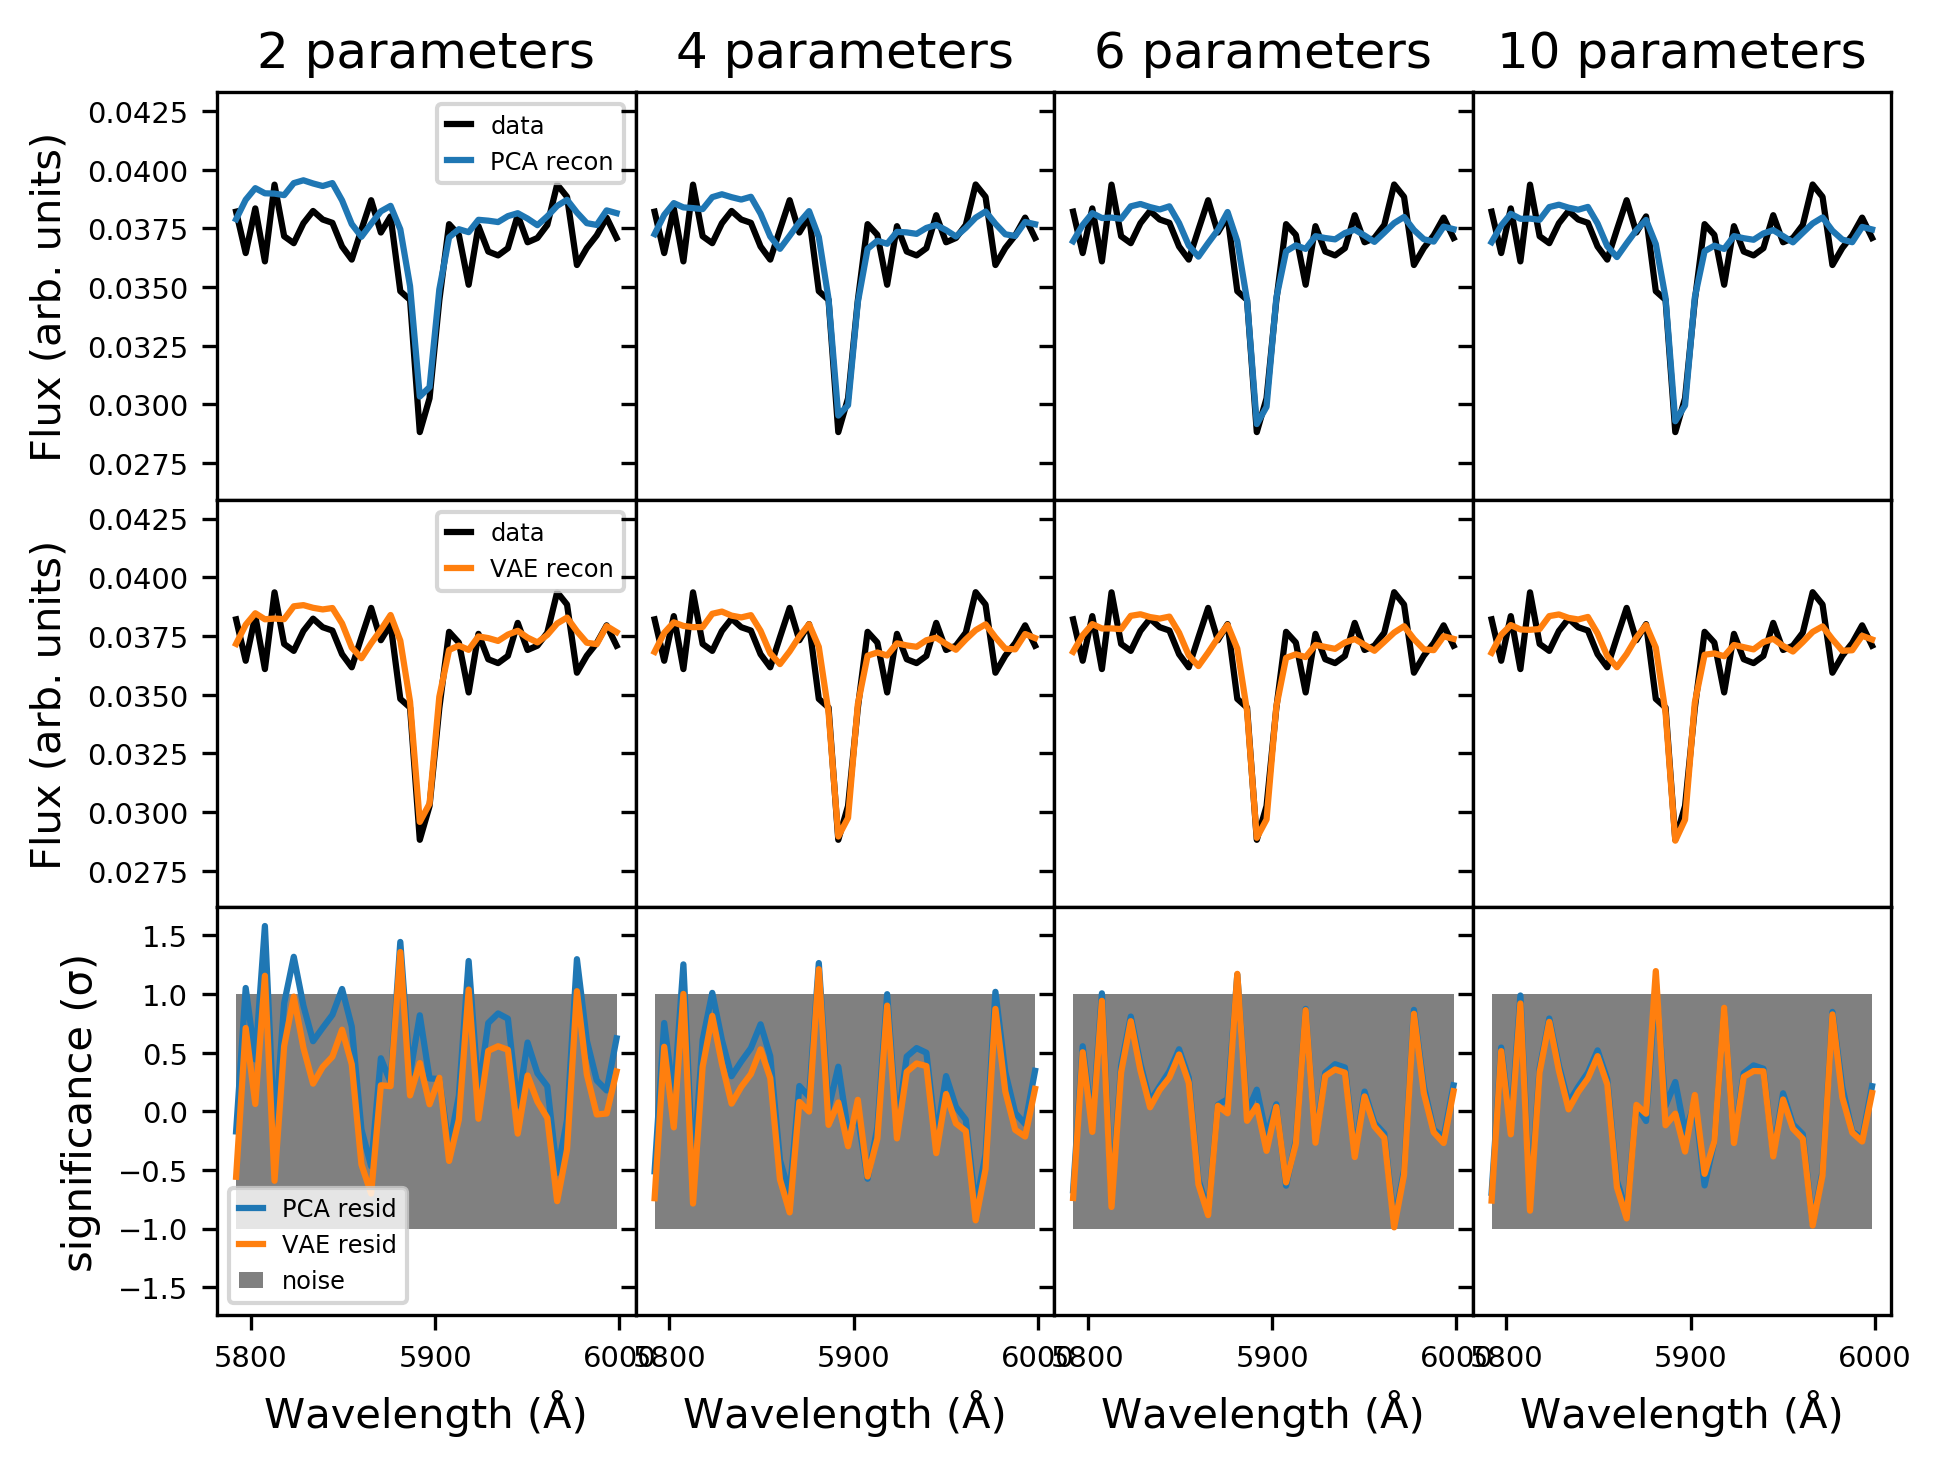

median SNR in window 18.284606525022582


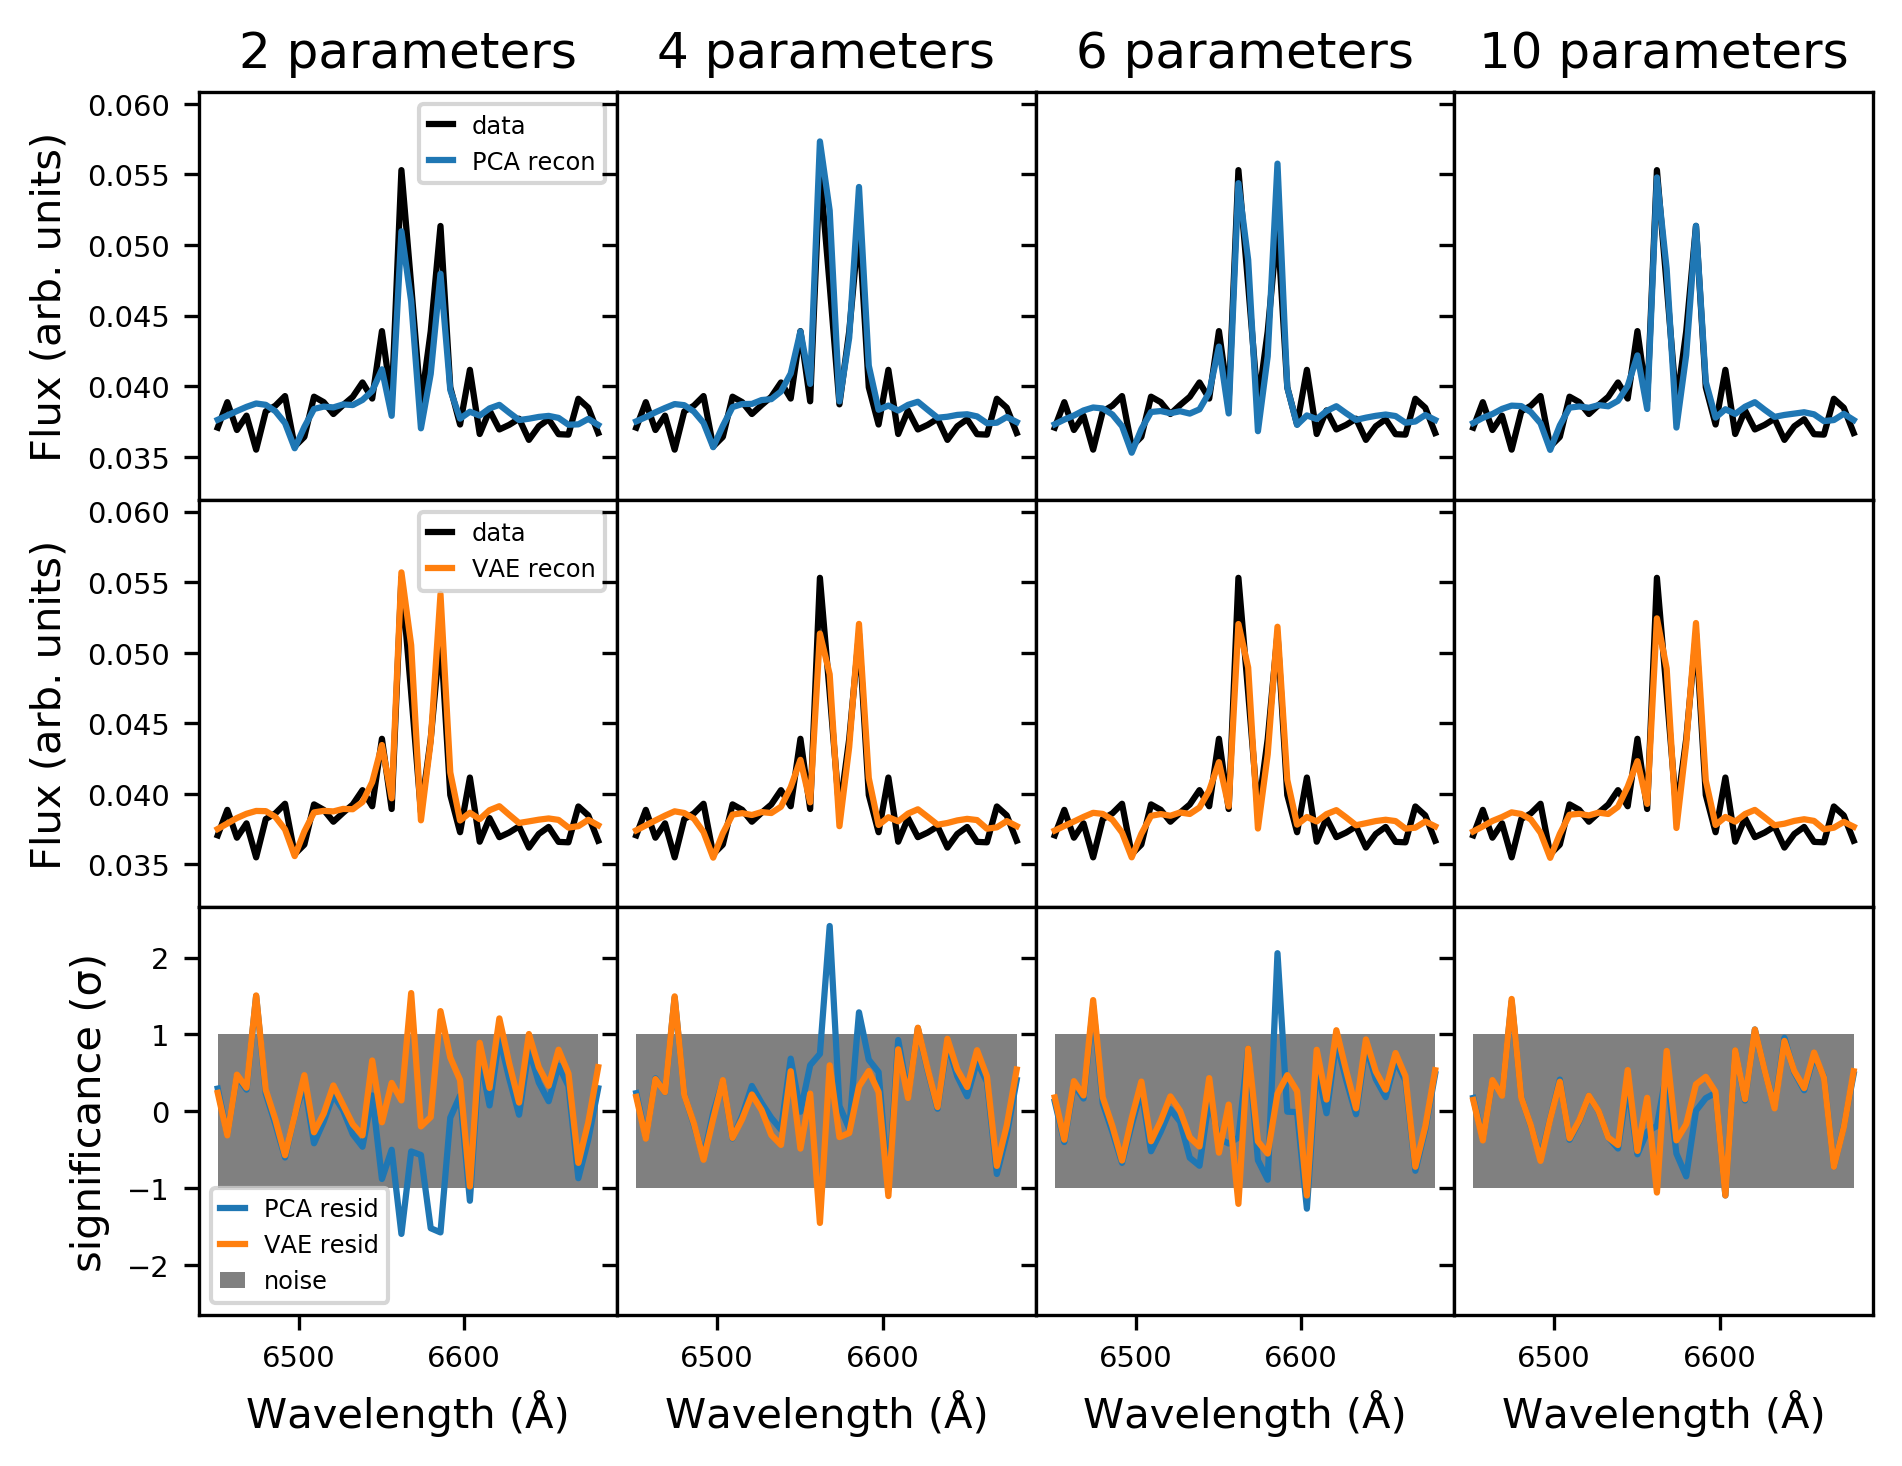

In [36]:
zoomin(7083, [5896, 6565], tag='loSNR')

# Look at outliers

In [37]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
lof.fit(latentmu_PCA)
outidx = np.argsort(lof.negative_outlier_factor_)

In [38]:
for i in range(10):
    j = outidx[i]
    print('%i, %i, %i' % (plate_mjd_fiber[j,0], plate_mjd_fiber[j,1], plate_mjd_fiber[j,2]))

346, 51693, 228
367, 51997, 524
359, 51821, 1
374, 51791, 328
299, 51671, 301
328, 52282, 8
395, 51783, 603
401, 51788, 414
477, 52026, 133
285, 51930, 175


In [39]:
for i in range(10):
    j = outidx[i]
    print('O%i & %i & %i & %i \\\\' % (i+1, plate_mjd_fiber[j,0], plate_mjd_fiber[j,1], plate_mjd_fiber[j,2]))

O1 & 346 & 51693 & 228 \\
O2 & 367 & 51997 & 524 \\
O3 & 359 & 51821 & 1 \\
O4 & 374 & 51791 & 328 \\
O5 & 299 & 51671 & 301 \\
O6 & 328 & 52282 & 8 \\
O7 & 395 & 51783 & 603 \\
O8 & 401 & 51788 & 414 \\
O9 & 477 & 52026 & 133 \\
O10 & 285 & 51930 & 175 \\


In [40]:
def plot_outliers(subsel, offset=3):
    specout = spec[outidx[subsel]].copy()
    weigout = spec_weig[outidx[subsel]]

    specout /= np.mean(np.abs(specout), axis=1)[:,None]
    specoutfil = specout.copy()
    specoutfil[weigout == 0] = float('nan')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for i in range(len(subsel)):
        plt.plot(lam, specout[i] + offset*i, zorder=-i-0.01, c=colors[subsel[i]], alpha=0.5)
        plt.plot(lam, specoutfil[i] + offset*i, zorder=-i, c=colors[subsel[i]])
        plt.text(lam[-1], specout[i,-1] + i*offset, 'O%i' % (subsel[i]+1), color=colors[subsel[i]], fontsize='small')
    plt.xlim((3250,8800))

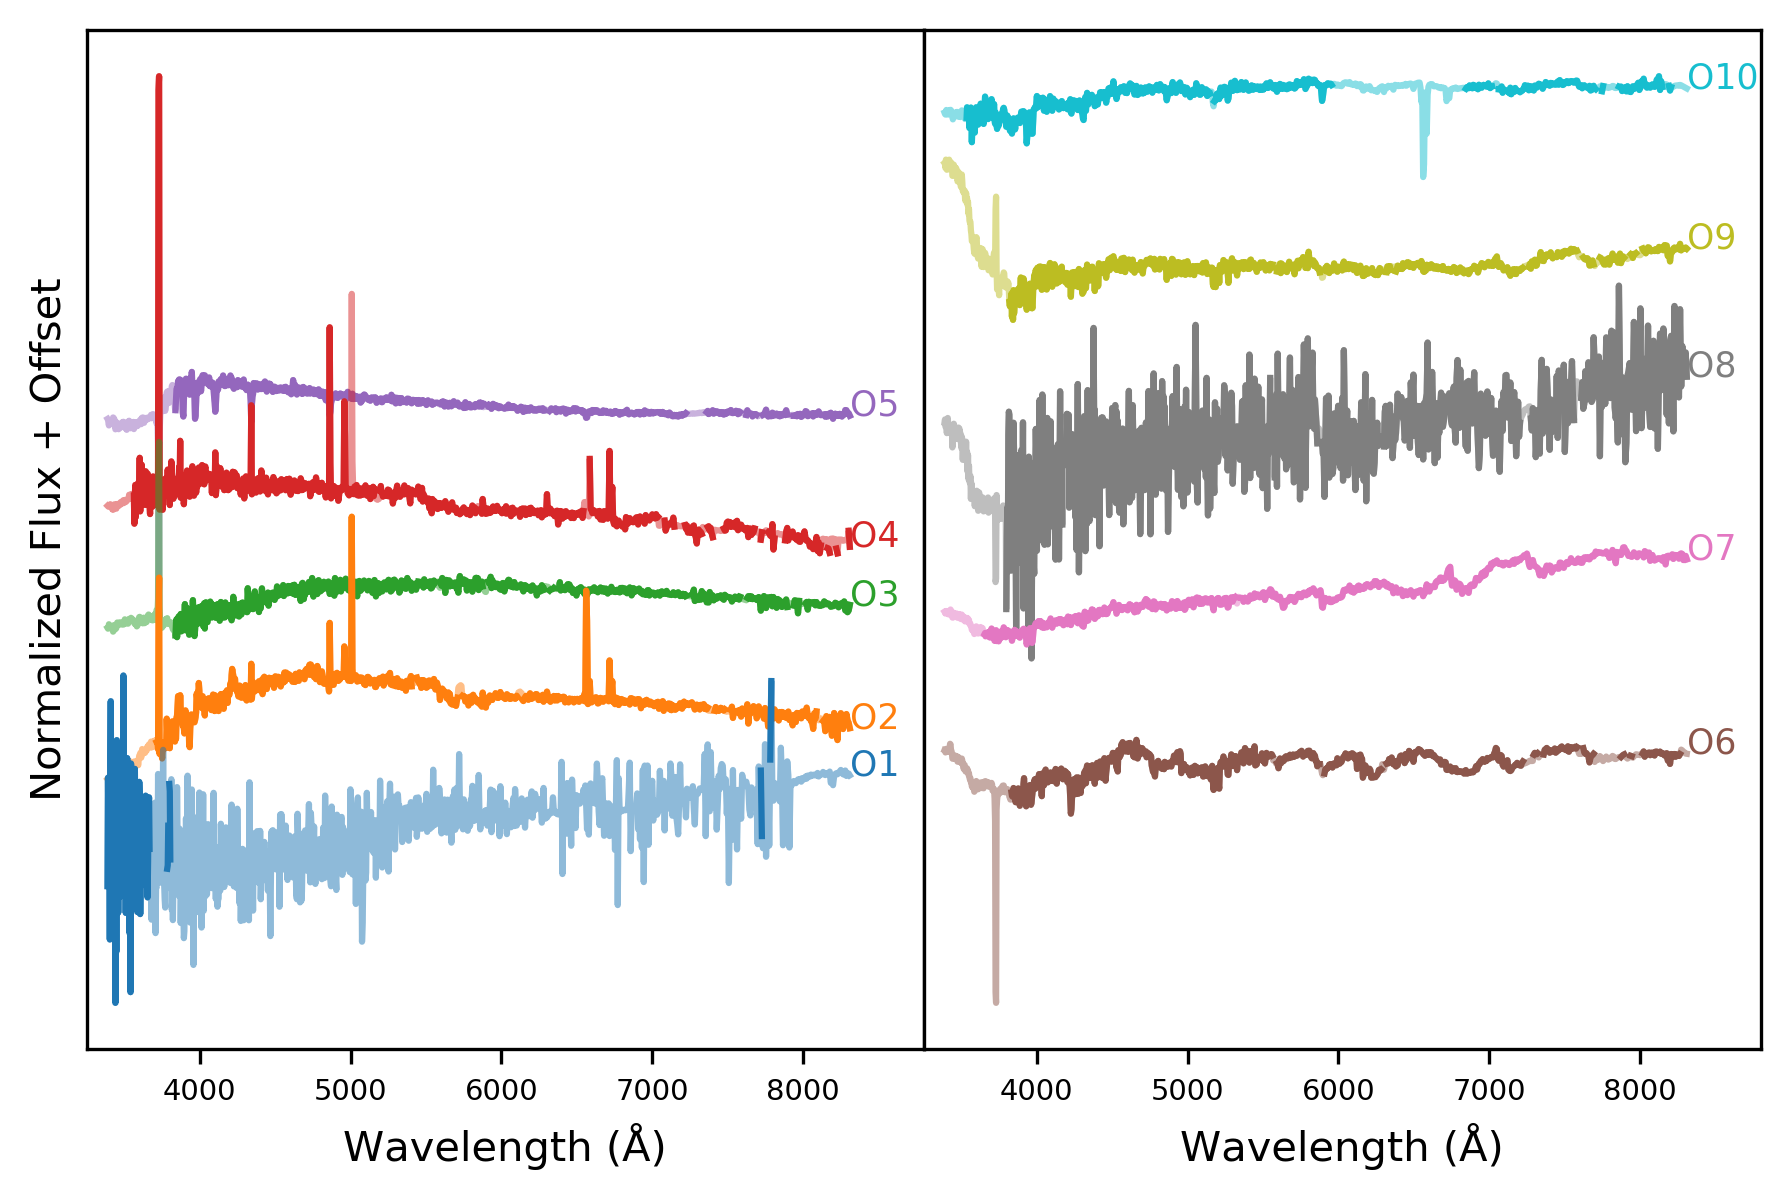

In [41]:
fig = plt.figure(figsize=(7.2,4.5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
plt.subplot(1,2,1)
plt.ylabel('Normalized Flux + Offset')
plt.yticks([])
plt.xlabel('Wavelength (Å)')
plot_outliers(range(0,5))
plt.subplot(1,2,2)
plot_outliers(range(5,10))
plt.yticks([])
plt.xlabel('Wavelength (Å)')
plt.savefig('figures/outliers.pdf')
plt.show()

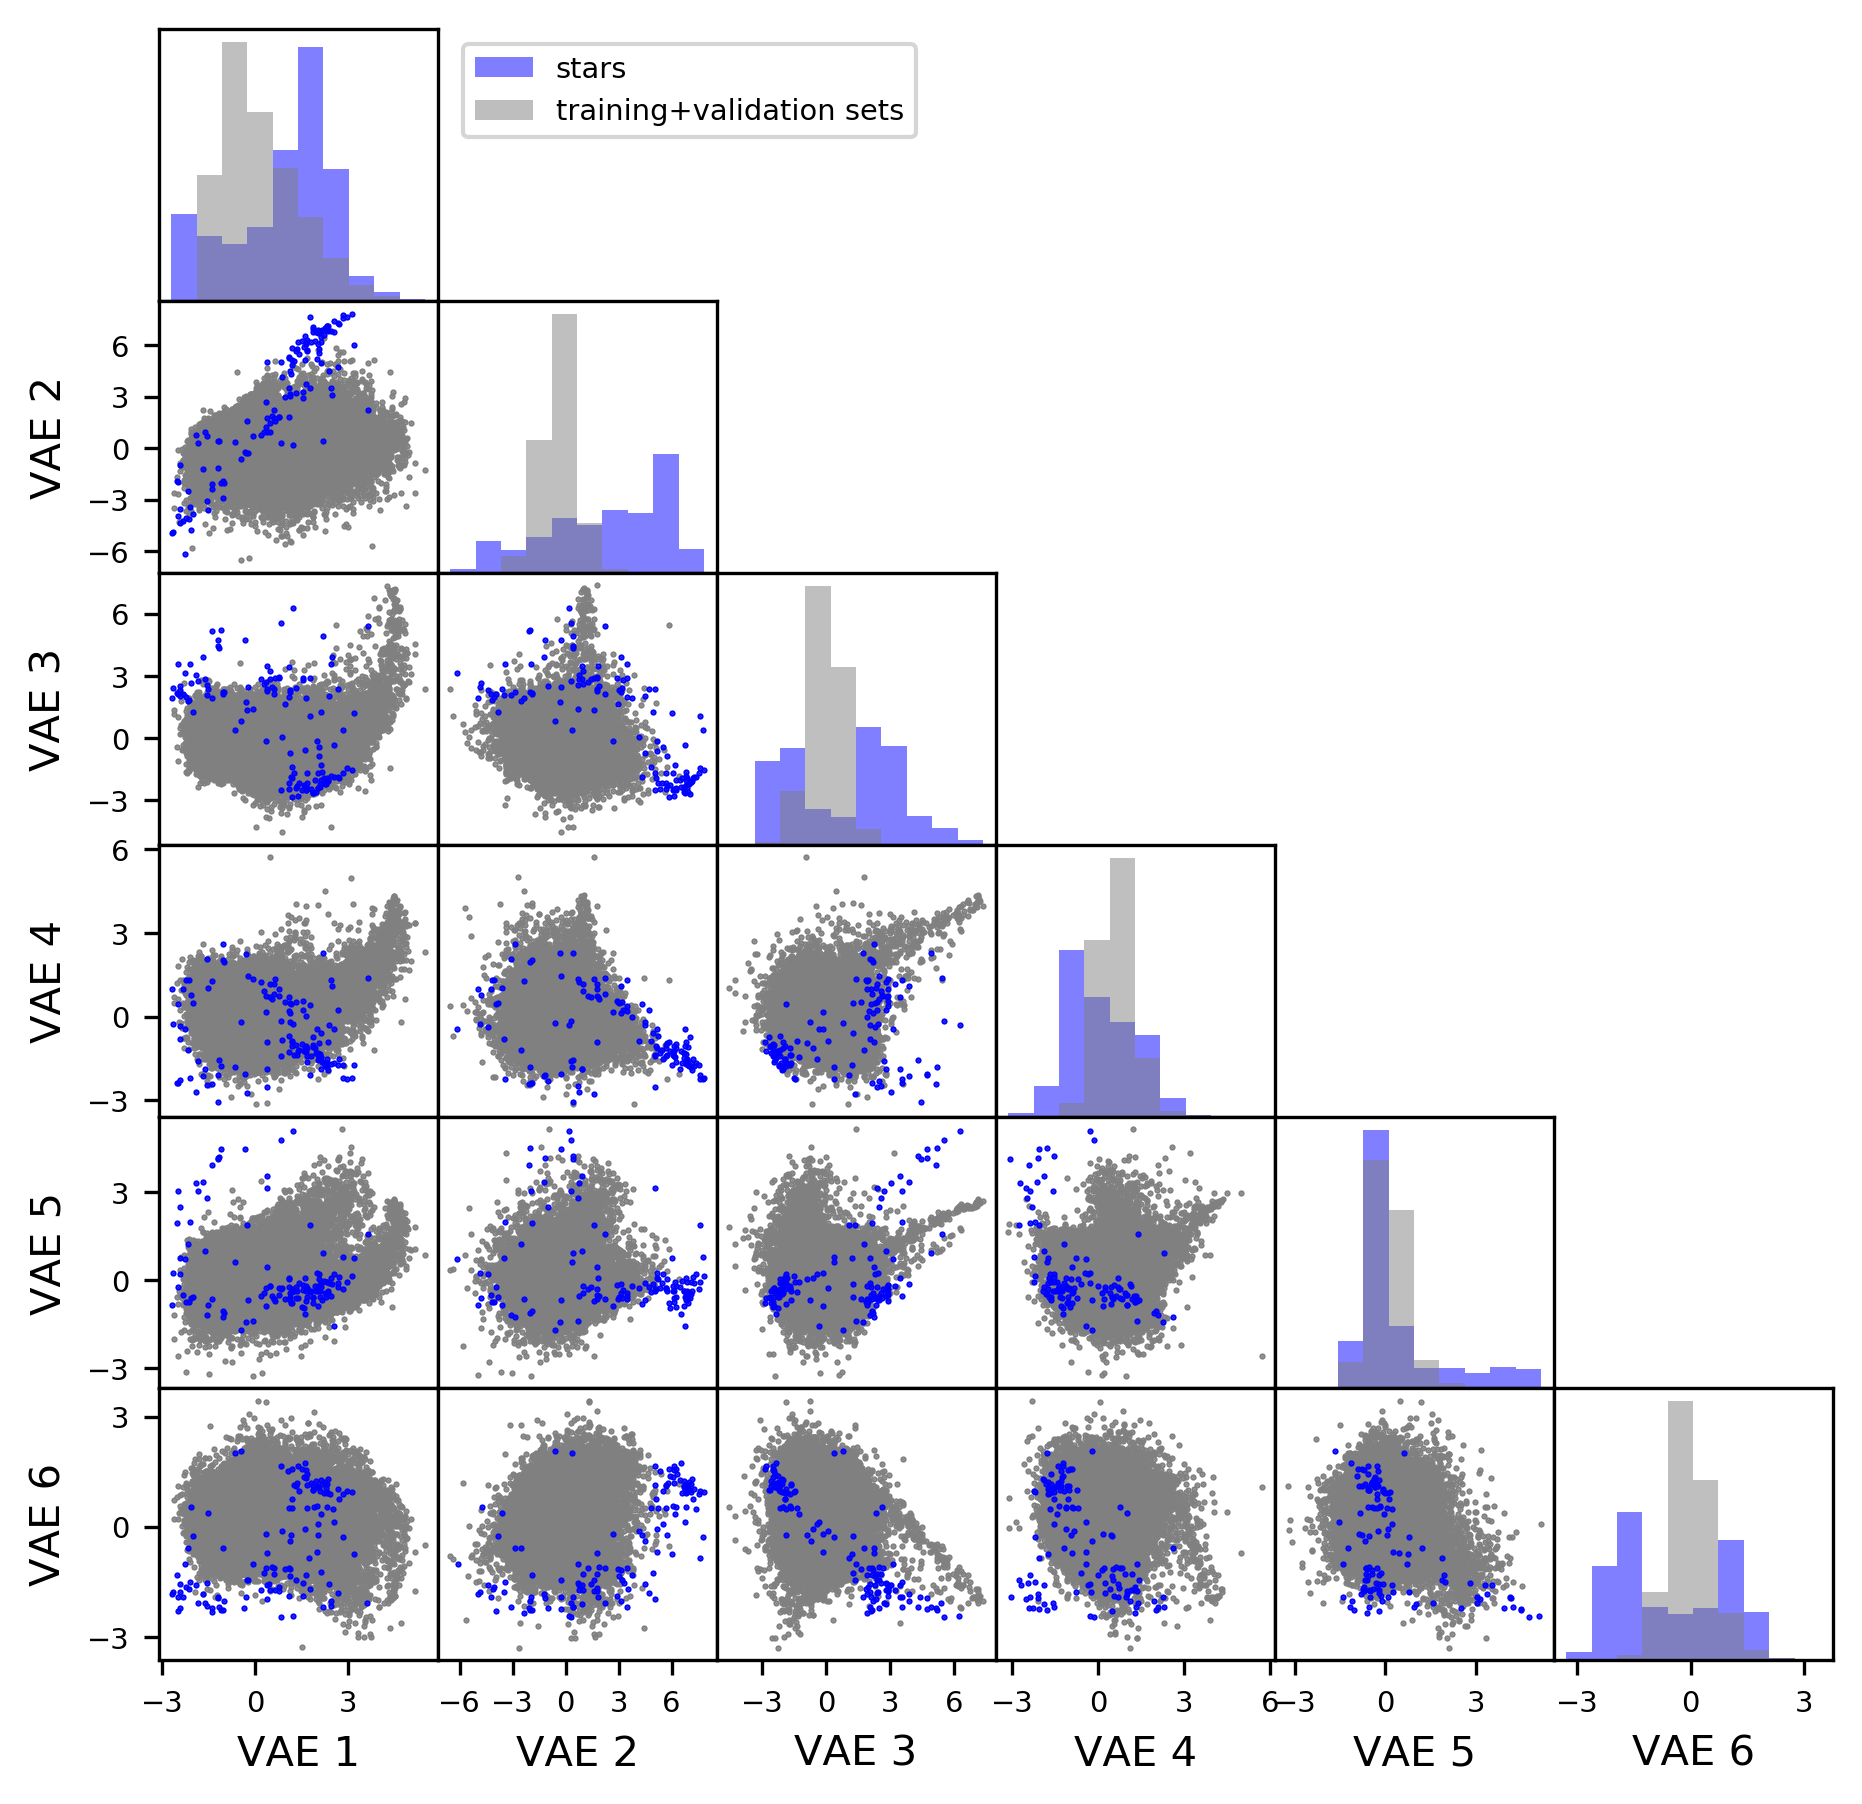

In [42]:
samplestars = np.where(stars)[0][::10]
fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(6):
    for j in range(6):
        if i <= j:
            plt.subplot(6,6,i+j*6+1)
            if i == 0 and j != 0:
                plt.ylabel('VAE %i' % (j + 1))
            if j == 5:
                plt.xlabel('VAE %i' % (i + 1))
            if i != 0:
                plt.yticks([])
            else:
                plt.yticks([-6,-3,0,3,6])
            if j != 5:
                plt.xticks([])
            else:
                plt.xticks([-6,-3,0,3,6])
            if i < j:
                plt.scatter(latentmu_PCA[allidx,i], latentmu_PCA[allidx,j],s=1,marker='.',c='grey')
                plt.scatter(latentmu_PCA[samplestars,i], latentmu_PCA[samplestars,j],s=1,marker='.',c='blue')
                
            if i == j:
                plt.hist([latentmu_PCA[allidx, i], latentmu_PCA[stars,i]], density=True, histtype='stepfilled', alpha=0.5, \
                         label=['training+validation sets', 'stars'], \
                         color=['grey', 'blue'])
                plt.yticks([])
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.savefig('figures/cornerplot_stars.png')
plt.show()

# Sensitivity to Noise

In [43]:
n_noise = 10000
imax = 6884
with torch.no_grad():
    model.eval()
    noise_lvls = 10**(np.linspace(-3.5, -2, 10))
    SNRs = np.nanmedian((spec[valididx[imax]])[:,None] / np.sqrt(spec_err[valididx[imax]][:,None]**2 + noise_lvls[None,:]**2), axis=0)    
    var_encoding = np.zeros((model.ncode, len(noise_lvls)))
    med_encodvar = np.zeros((model.ncode, len(noise_lvls)))
    bias_encoding = np.zeros((model.ncode, len(noise_lvls)))
    for i, noise in enumerate(noise_lvls):
        spec_noise_t = torch.tensor(spec[valididx[imax]][None,:] - meanspec + noise * np.random.normal(size=(n_noise, nfeat)), dtype=torch.float32)
        recon_batch_noise, mu_noise, logvar_noise = model(spec_noise_t)
        var_encoding[:, i] = np.var(mu_noise.numpy(), axis=0)
        bias_encoding[:, i] = np.mean(mu_noise.numpy(), axis=0) - latentmu[valididx[imax]]
        med_encodvar[:, i] = np.median(logvar_noise.numpy(), axis=0)

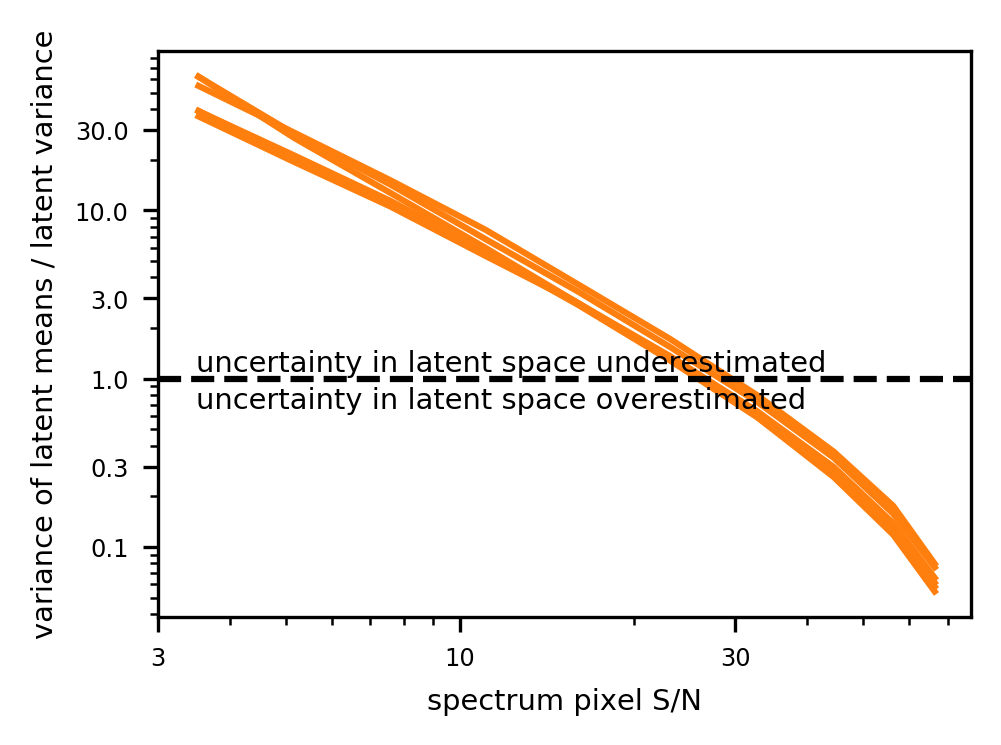

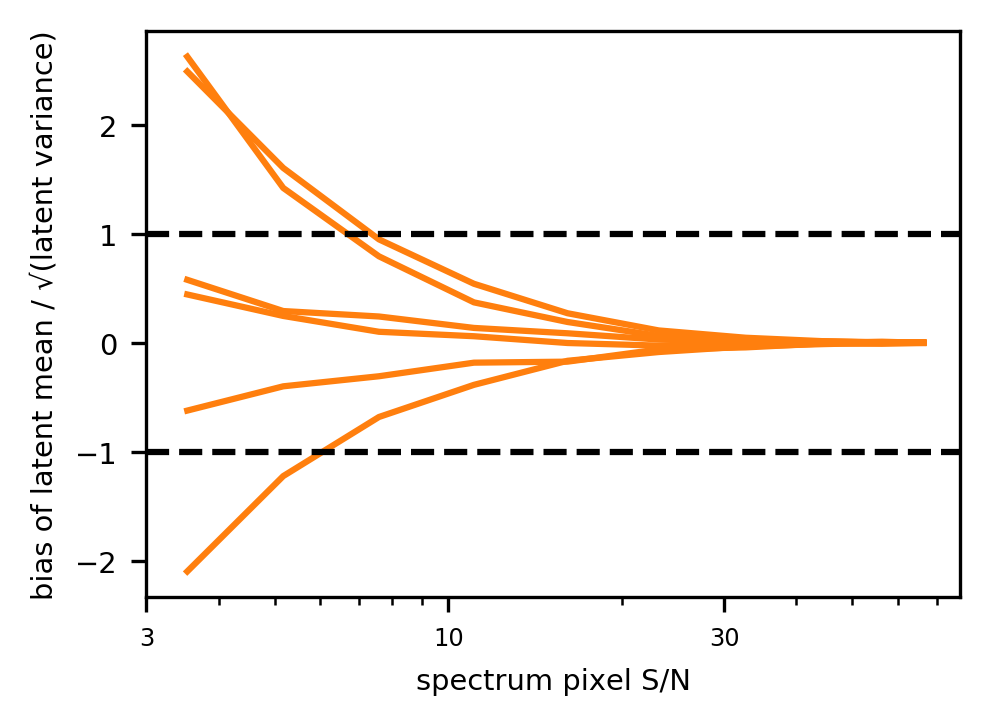

In [44]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize=(3.5,2.5))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
dimbylv = np.argsort(np.median(latentlv, axis=0))
for j in range(6):
    i = dimbylv[j]
    label1, label2 = None, None
    plt.loglog(SNRs, var_encoding[i,:] / np.exp(med_encodvar[i,:]), c=colors[1])
plt.ylabel('variance of latent means / latent variance', fontsize='x-small')
plt.axhline(1, c='k', ls='--')
plt.xlabel('spectrum pixel S/N', fontsize='x-small')
plt.xticks([3,10,30], fontsize='xx-small')
plt.yticks([0.1, 0.3, 1, 3, 10, 30], fontsize='xx-small')
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.get_yaxis().set_major_formatter(ScalarFormatter())
plt.text(3.5, 1.1, 'uncertainty in latent space underestimated', fontsize='x-small')
plt.text(3.5, 0.9, 'uncertainty in latent space overestimated', verticalalignment='top', fontsize='x-small')
plt.savefig('figures/noise_zvariance.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(3.5,2.5))
for j in range(6):
    i = dimbylv[j]
    std = np.sqrt(np.exp(med_encodvar[i,:]))
    plt.plot(SNRs, bias_encoding[i,:] / np.exp(0.5*med_encodvar[i,:]), c=colors[1])
plt.axhline(1, ls='--', c='k')
plt.axhline(-1, ls='--', c='k')
plt.xscale('log')
ax.get_xaxis().set_major_formatter(ScalarFormatter())
plt.xticks([3,10,30], fontsize='xx-small')
plt.xlabel('spectrum pixel S/N', fontsize='x-small')
plt.ylabel('bias of latent mean / √(latent variance)', fontsize='x-small')
plt.savefig('figures/noise_zbias.pdf')
plt.show()